# DATA 620, Project 2

### Group 1 Members:

* Mauricio Alarcon
* Sekhar Mekala 
* Aadi Kalloo
* Srinivasa Illapani
* Param Singh 

### Project Requirements

Identify a large 2-node network dataset—you can start with a dataset in a repository.  

1. Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

You may work in a small group on the project.

Your code and analysis should be delivered in an IPython Notebook by end of day Monday July 3rd. 

## Analyzing Co-Products Using Graph Techniques

The objective of this project is to perform an exploratory analysis of a large 2-node graph consisting of items purchased during a weekend at a major retailer.

We seek to gain insights on:

* Top Rakning Products
* Product Islands/Communities
* Related Product Categories
* Product Recommendations

## Dataset Description

This is a proprietary dataset consisting of 123,716 purchase transactions at a major retailer for a weekend in the month of June. We're representing this transactional dataset ias a bipirtite graph with edges bewtween two node types: Customer Orders (n=16,313) and Products (n=2,167).

The primary focus of analysis is the products network, for which we have a de-identified product name and category. Once we project the graph onto the products, we will be able to analyze co-products and other important metrics.

## Data Loading

In this section we will: 

* Load the data from CSV format into a pandas dataframe 
* Create a Graph using from the pandas dataframe and populate the product attributes


In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import stats
import numpy as np
from prettytable import PrettyTable

In [2]:
prod = pd.read_csv('co-products.csv')
prod.head(n=20)


order_id  product_id                    product_desc  \
0   10185341     3314604                   CHERRIES BULK   
1   10244355      472832     REP2 SUM FRSH HAM SERV DELI   
2   10244547     1013780        REP2 SUM FRESH SODA DELI   
3   10401922     1921107             MILK PCC RFRG DAIRY   
4   10411766     2542615                AIR CARE CANDLES   
5   10414438      509272         PASTRIES SUM FRZ BAKERY   
6   10432453     2876259                         KETCHUP   
7   10558119     2892515         APPLESAUCE SINGLE SERVE   
8   10615817     1457537  COATED SEASONED POPCORN SNACKS   
9   10658392      790193                    EGGPLANT FRH   
10  10697639     1921107             MILK PCC RFRG DAIRY   
11  10704779     1753852                   ALUMINUM FOIL   
12  10709022     1652380           MANUAL DISH DETERGENT   
13  10818634     2258594           ALL FAMILY RTE CEREAL   
14  10881674     1657966     MILK ALTERNATIVE RFRG DAIRY   
15  10893873     1817120       VALUE PIZZA MULTI SRV FRZ   
16  10906232     1848094      ALL FAMILY POWDERED DRINKS   
17  11004308     2679694                   ROMA TOMATOES   
18  11030560     1676772                    BROCCOLI FRZ   
19  11044888      374518                   SALAD SPINACH   

                     cat_desc  
0                    CHERRIES  
1          DELI SERVICE MEATS  
2               DELI BEVERAGE  
3    MILK CONVNTNL RFRG DAIRY  
4                    AIR CARE  
5          BAKERY SWEET GOODS  
6                     KETCHUP  
7              PACKAGED FRUIT  
8                SALTY SNACKS  
9              DRY VEGETABLES  
10   MILK CONVNTNL RFRG DAIRY  
11               FOOD STORAGE  
12             DISH DETERGENT  
13        READY TO EAT CEREAL  
14  MILK SPECIALTY RFRG DAIRY  
15               FROZEN PIZZA  
16             BEVERAGE MIXES  
17                   TOMATOES  
18          FROZEN VEGETABLES  
19                     SALADS

In [3]:
print(prod.shape)

(123716, 4)


Let's now extract the list of procut and order nodes. For the product nodes we will preserve the description and category attributes.

In [4]:
order_nodes  = prod[['order_id']].drop_duplicates()
unique_products  = prod[['product_id','product_desc','cat_desc']].drop_duplicates()
print 'Unique Orders: ' + str(len(order_nodes))
print 'Unique Products: '+ str(len(unique_products))

Unique Orders: 16313
Unique Products: 2167


In [5]:
product_nodes = unique_products.product_id.unique
product_nodes_attr = unique_products[['product_desc','cat_desc']].to_dict().values()

And now, let's create the Order-Product graph:

In [6]:
K = nx.from_pandas_dataframe(prod,'order_id','product_id',create_using=nx.DiGraph())

In [7]:
print(nx.info(K))

Name: 
Type: DiGraph
Number of nodes: 18480
Number of edges: 123716
Average in degree:   6.6946
Average out degree:   6.6946


In [8]:
len(K.edges())

123716

and populate the product attributes

In [9]:
nx.set_node_attributes(K, 'type', pd.Series('order', index=order_nodes.order_id).to_dict())
nx.set_node_attributes(K, 'type', pd.Series('product', index=unique_products.product_id).to_dict())

x = unique_products.product_desc
x.index = unique_products.product_id
nx.set_node_attributes(K, 'product_desc', x.to_dict())


x = unique_products.cat_desc
x.index = unique_products.product_id
nx.set_node_attributes(K, 'cat_desc', x.to_dict())


Let's now calculate and compare the degree centrality and pagerank on the order-products graph and dump the results into a pandas dataframe:

In [10]:
# Rank elements of network using degree centrality
d = nx.degree(K)
# set the node attribute
nx.set_node_attributes(K, 'degree_op', d)

# Rank elements of network using degree centrality
dc = nx.degree_centrality(K)
# set the node attribute
nx.set_node_attributes(K, 'degree_centrality_op', dc)

# Rank elements of network using pagerank
pr = nx.pagerank(K)
# set the node attribute
nx.set_node_attributes(K, 'pagerank_op', pr)


Let's now look at the category rankings for the products, looking at the top 20 by degree centrality and pagerank: 

In [11]:
#pull out all the nodes and convert to pandas DF
nodes = K.nodes(data=True)
df = pd.DataFrame([node[1] for node in nodes])
df.id = [node[0] for node in nodes]
df.sort_values(by='degree_centrality_op',ascending=False).head(20)


cat_desc  degree_centrality_op  degree_op  \
6724                         BANANAS              0.115807       2140   
11489       MILK CONVNTNL RFRG DAIRY              0.097516       1802   
14085                        BERRIES              0.074301       1373   
186                     SALTY SNACKS              0.060014       1109   
4653        EGGS CONVNTNL RFRG DAIRY              0.059311       1096   
14977                       BREAD SS              0.056713       1048   
9854         BUNS AND ROLLS BREAD SS              0.053628        991   
14674  SHREDS AND CHUNKS PKGD CHEESE              0.052330        967   
8375                    SALTY SNACKS              0.052221        965   
10752                      ICE CREAM              0.048704        900   
4325                       CUCUMBERS              0.047568        879   
10899                        BERRIES              0.047568        879   
2808                        CHERRIES              0.047135        871   
506       ABOVE PREMIUM QUALITY BEER              0.043888        811   
13277                 WET VEGETABLES              0.043509        804   
5949                          MELONS              0.041615        769   
13929              ONIONS AND GARLIC              0.040695        752   
6421               YOGURT RFRG DAIRY              0.040100        741   
8097          CARBONATED SOFT DRINKS              0.039829        736   
2967                           WATER              0.037881        700   

       pagerank_op                    product_desc     type  
6724      0.005717                    BANANAS BULK  product  
11489     0.005038             MILK PCC RFRG DAIRY  product  
14085     0.003328                STRAWBERRIES FRH  product  
186       0.003290                    POTATO CHIPS  product  
4653      0.002449        EGGS CONVNTNL RFRG DAIRY  product  
14977     0.002547               EVERYDAY BREAD SS  product  
9854      0.002519  HAMBURGER HOTDOG BUNS BREAD SS  product  
14674     0.001692        SHREDDED PACKAGED CHEESE  product  
8375      0.002346     NACHOS ROUND TORTILLA CHIPS  product  
10752     0.003340                       ICE CREAM  product  
4325      0.001520              CUCUMBERS PACKAGED  product  
10899     0.002163                 RASPBERRIES FRH  product  
2808      0.002641                   CHERRIES BULK  product  
506       0.005365                      CRAFT BEER  product  
13277     0.001922                   ASPARAGUS SUM  product  
5949      0.002088                      WATERMELON  product  
13929     0.001430                     ONIONS BULK  product  
6421      0.001719                GREEK RFRG DAIRY  product  
8097      0.009241     SGL SRV BTLE CARB SFT DRINK  product  
2967      0.003330        WATER SNGL SRV MULTIPACK  product

In [12]:
df[df.type=='product'].sort_values(by='pagerank_op',ascending=False).head(20)

cat_desc  degree_centrality_op  degree_op  \
5973                   CIGARETTES              0.029872        552   
8097       CARBONATED SOFT DRINKS              0.039829        736   
6724                      BANANAS              0.115807       2140   
17320               DELI BEVERAGE              0.018724        346   
506    ABOVE PREMIUM QUALITY BEER              0.043888        811   
14763        ALTERNATIVE BEVERAGE              0.022079        408   
11489    MILK CONVNTNL RFRG DAIRY              0.097516       1802   
14787                       WATER              0.019698        364   
5003                          ICE              0.016289        301   
12788          FRANCHISE BEVERAGE              0.008767        162   
10752                   ICE CREAM              0.048704        900   
1002           FRANCHISE BEVERAGE              0.009091        168   
2967                        WATER              0.037881        700   
13572  CANDY GUM AND MINTS SINGLE              0.020672        382   
14085                     BERRIES              0.074301       1373   
186                  SALTY SNACKS              0.060014       1109   
11732               BAKERY DONUTS              0.019806        366   
5039   CANDY GUM AND MINTS SINGLE              0.021322        394   
12576      CARBONATED SOFT DRINKS              0.037340        690   
6316         ALTERNATIVE BEVERAGE              0.024785        458   

       pagerank_op                    product_desc     type  
5973      0.011349   CARTON SINGLE PACK CIGARETTES  product  
8097      0.009241     SGL SRV BTLE CARB SFT DRINK  product  
6724      0.005717                    BANANAS BULK  product  
17320     0.005383        REP2 SUM FRESH SODA DELI  product  
506       0.005365                      CRAFT BEER  product  
14763     0.005333                   ENERGY DRINKS  product  
11489     0.005038             MILK PCC RFRG DAIRY  product  
14787     0.004594              WATER SINGLE SERVE  product  
5003      0.004038                             ICE  product  
12788     0.003497  SUM ICED LATTE TEA FRAPPUCCINO  product  
10752     0.003340                       ICE CREAM  product  
1002      0.003340                SUM BEV ESPRESSO  product  
2967      0.003330        WATER SNGL SRV MULTIPACK  product  
13572     0.003329          CHOCOLATE SINGLE CANDY  product  
14085     0.003328                STRAWBERRIES FRH  product  
186       0.003290                    POTATO CHIPS  product  
11732     0.003257           DONUTS SUM FRZ BAKERY  product  
5039      0.003205                      GUM SINGLE  product  
12576     0.003096     MLT SRV BTLE CARB SFT DRINK  product  
6316      0.003071              READY TO DRINK TEA  product

In [13]:
prod[prod.order_id.isin(prod[prod.product_desc=='CARTON SINGLE PACK CIGARETTES'].order_id.tolist())].sort_values(by='order_id')

order_id  product_id                   product_desc  \
73685   10017612      109159  CARTON SINGLE PACK CIGARETTES   
73872   10031259      109159  CARTON SINGLE PACK CIGARETTES   
16043   10037147      109159  CARTON SINGLE PACK CIGARETTES   
13401   10047857      109159  CARTON SINGLE PACK CIGARETTES   
60080   10051055      109159  CARTON SINGLE PACK CIGARETTES   
52356   10051059      109159  CARTON SINGLE PACK CIGARETTES   
119782  10051060      109159  CARTON SINGLE PACK CIGARETTES   
111216  10057235      109159  CARTON SINGLE PACK CIGARETTES   
105648  10075200      109159  CARTON SINGLE PACK CIGARETTES   
41596   10083395     1051427          READY TO DRINK COFFEE   
40574   10083395      109159  CARTON SINGLE PACK CIGARETTES   
26327   10096634      109159  CARTON SINGLE PACK CIGARETTES   
797     10096634     1051427          READY TO DRINK COFFEE   
17532   10099320      109159  CARTON SINGLE PACK CIGARETTES   
71526   10105961      109159  CARTON SINGLE PACK CIGARETTES   
8161    10105961     1921107            MILK PCC RFRG DAIRY   
76843   10105965      109159  CARTON SINGLE PACK CIGARETTES   
53485   10106071      109159  CARTON SINGLE PACK CIGARETTES   
49446   10124308      109159  CARTON SINGLE PACK CIGARETTES   
67522   10124384      109159  CARTON SINGLE PACK CIGARETTES   
80385   10124403      109159  CARTON SINGLE PACK CIGARETTES   
95837   10149358      109159  CARTON SINGLE PACK CIGARETTES   
30544   10149358     2742314    MLT SRV BTLE CARB SFT DRINK   
65676   10164120      109159  CARTON SINGLE PACK CIGARETTES   
88555   10164120     1051427          READY TO DRINK COFFEE   
81794   10179005      109159  CARTON SINGLE PACK CIGARETTES   
91162   10179005     1642620                    MOIST SNUFF   
120856  10185247      109159  CARTON SINGLE PACK CIGARETTES   
122455  10185247     1013780       REP2 SUM FRESH SODA DELI   
110862  10191074      109159  CARTON SINGLE PACK CIGARETTES   
...          ...         ...                            ...   
62158   13315800      510265                   CIGARS LARGE   
85799   13315800      109159  CARTON SINGLE PACK CIGARETTES   
72135   13318607      109159  CARTON SINGLE PACK CIGARETTES   
81204   13321018      109159  CARTON SINGLE PACK CIGARETTES   
3624    13334659      109159  CARTON SINGLE PACK CIGARETTES   
8297    13354963      109159  CARTON SINGLE PACK CIGARETTES   
100784  13372621      109159  CARTON SINGLE PACK CIGARETTES   
49441   13372622     2569038       REP1 DTL FRSH SUSHI DELI   
25306   13372622      109159  CARTON SINGLE PACK CIGARETTES   
23285   13389547      895195            LIGHT DOMESTIC BEER   
44899   13389547      109159  CARTON SINGLE PACK CIGARETTES   
107595  13389547     2595886                 NUTRITION BARS   
95063   13391259      109159  CARTON SINGLE PACK CIGARETTES   
3750    13391431     2902809      CAKE AND PASTRY SWT GD SS   
44842   13391431      109159  CARTON SINGLE PACK CIGARETTES   
112367  13391431      843499         CHOCOLATE SINGLE CANDY   
27143   13394469     2742314    MLT SRV BTLE CARB SFT DRINK   
49786   13394469      306435             READY TO DRINK TEA   
14426   13394469      109159  CARTON SINGLE PACK CIGARETTES   
47814   13400726      109159  CARTON SINGLE PACK CIGARETTES   
110645  13400726     1013780       REP2 SUM FRESH SODA DELI   
103093  13402722     1727318                     GUM SINGLE   
6868    13402722      109159  CARTON SINGLE PACK CIGARETTES   
117054  13402753      109159  CARTON SINGLE PACK CIGARETTES   
99351   13421428      856359      OTHER NUT AND SEED SNACKS   
118009  13421428     1727318                     GUM SINGLE   
104198  13421428      109159  CARTON SINGLE PACK CIGARETTES   
41653   13426590      109159  CARTON SINGLE PACK CIGARETTES   
25481   13426590     3054576     BELOW PREMIUM QUALITY BEER   
59646   13430758      109159  CARTON SINGLE PACK CIGARETTES   

                              cat_desc  
73685                       CIGARETTES  
73872              

## Product Islands

Let's look for islands in the product-product projection of the Graph. Before that, let's convert the graph to undirected and obtain the Product-Product projection

In [14]:
from networkx.algorithms import bipartite

K_ud = K.to_undirected()

# and get the connected components
P = bipartite.weighted_projected_graph(K_ud, unique_products.product_id.tolist())
P.edges(data=True)[0:5]

P_components = list(nx.connected_component_subgraphs(P))

#G = bipartite.weighted_projected_graph(K_ud, bottom_nodes)
#G.edges(data=True)[0:5]


In [15]:
print(nx.info(P))

Name: 
Type: Graph
Number of nodes: 2167
Number of edges: 288221
Average degree: 266.0092


In [16]:
def trim_edges( g, weight = 1): 
    g2 = nx.Graph() 
    for f, to, edata in g.edges( data = True): 
        if edata['weight'] > weight: 
            g2. add_edge( f, to, edata) 
    return g2

def island_method( g, iterations = 5): 
    weights = [edata['weight'] for f, to, edata in g.edges( data = True)] 
    mn = int( min( weights)) +50
    mx = int( max( weights)) 
    #compute the size of the step, so we get a reasonable step in iterations 
    step = int(( mx-mn)/ iterations) 
    return [[ threshold, trim_edges( g, threshold)] for threshold in [5,20,50,200,350,450]]#range( mn, mx, step)]

In [17]:
#for i in [island_method(p) for p in P_components]
islands = island_method(P_components[0],4)


In [26]:
def displayIslands(islands):
    for i in islands:
        # print the threshold level, size of the graph, and number of connected components ... \
        I_cc =  list( nx.connected_component_subgraphs( i[1]))
        print i[ 0], len( i[ 1]), len(I_cc)
        for I in I_cc:
            labels = {}
            for node in I.nodes(data=True):
                labels.update({node[0]:unique_products[unique_products.product_id==node[0]].product_desc.tolist()[0]})

            weights = [i[2].get('weight')*50 for i in I.edges(data=True)] 

            plt.figure(figsize=(20,20))
            pos = None
            if (len( I)>250):
                pos=nx.drawing.spring_layout(I)
            else: 
                pos=nx.drawing.circular_layout(I)
            nx.draw(I, pos, cmap=plt.get_cmap('jet'), node_size=weights, with_labels=True, labels=labels,alpha=0.5, k=0.5)




5 939 9
20 485 3
50 221 1
200 29 1
350 7 1
450 4 1


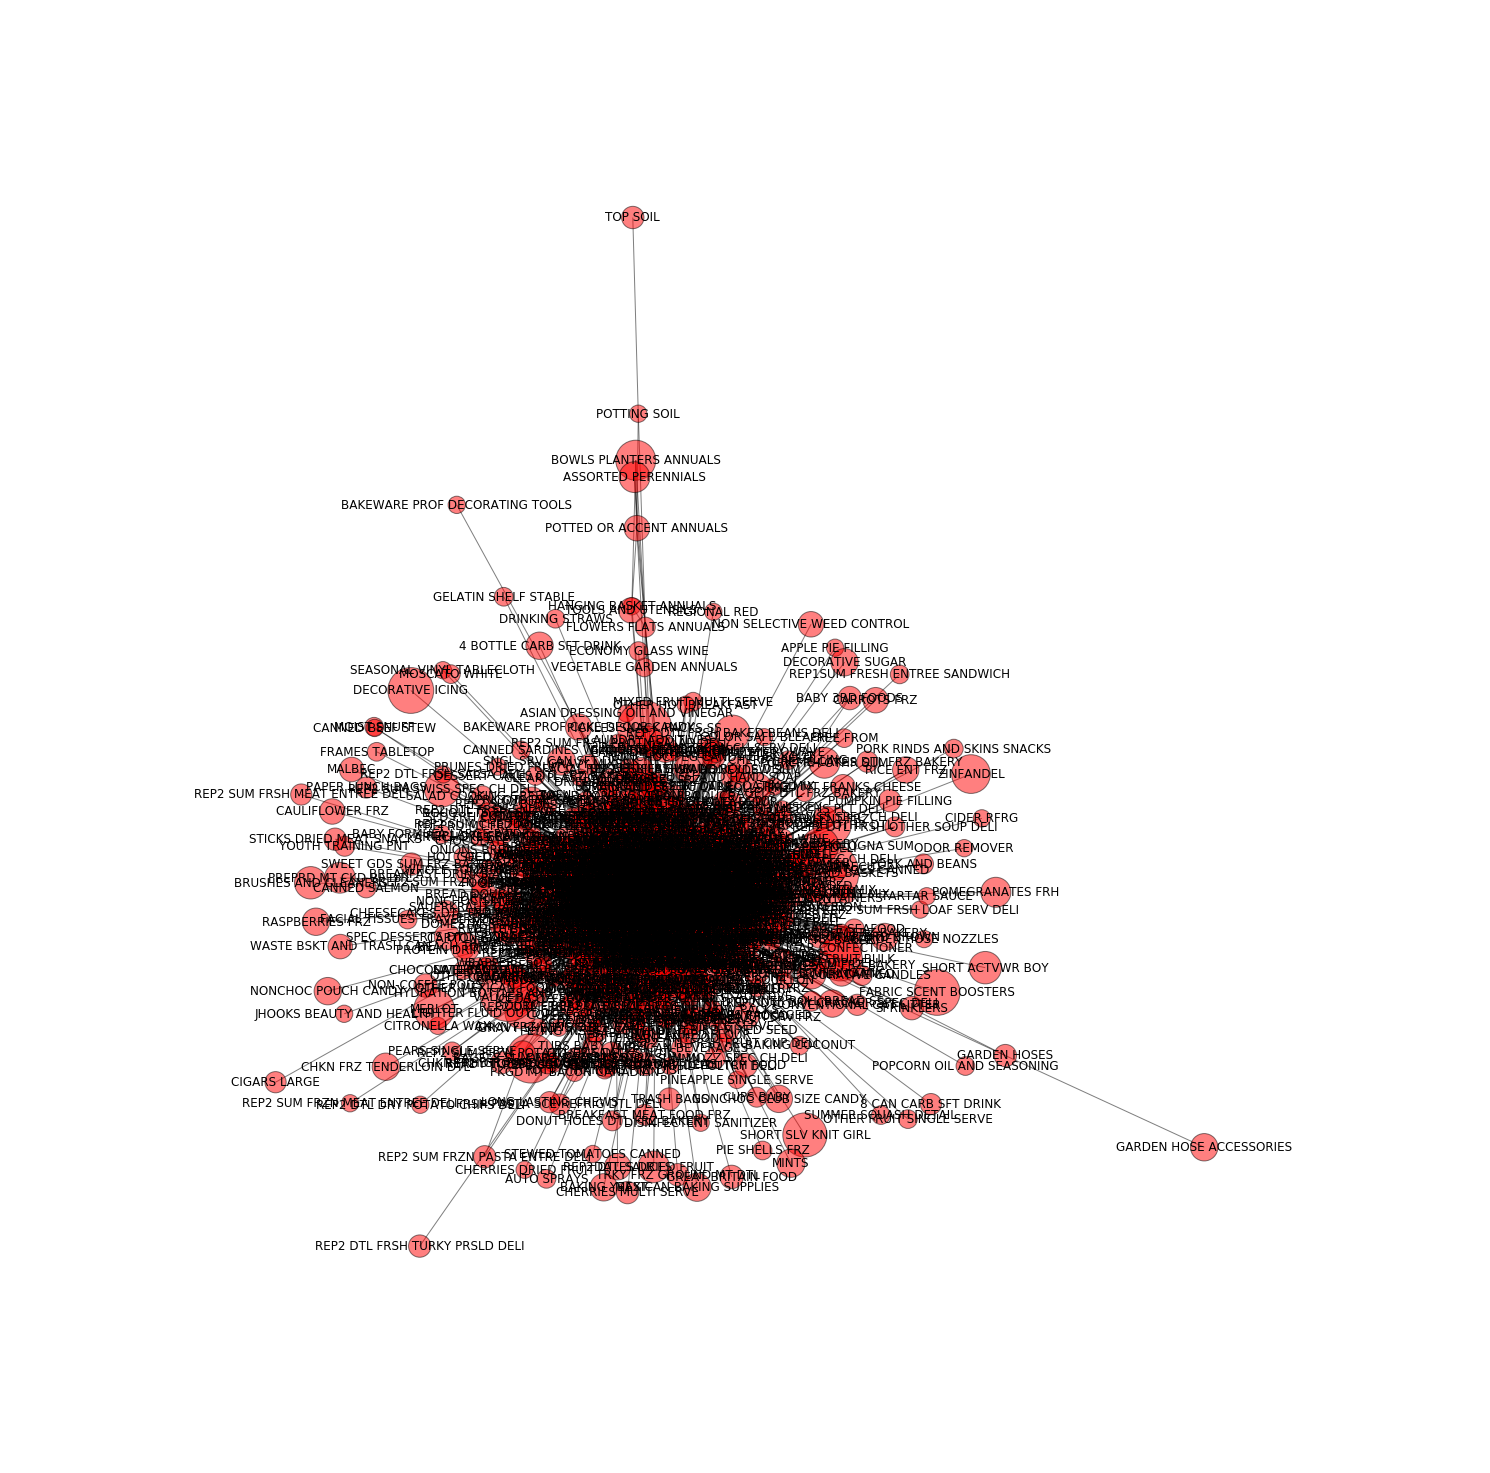

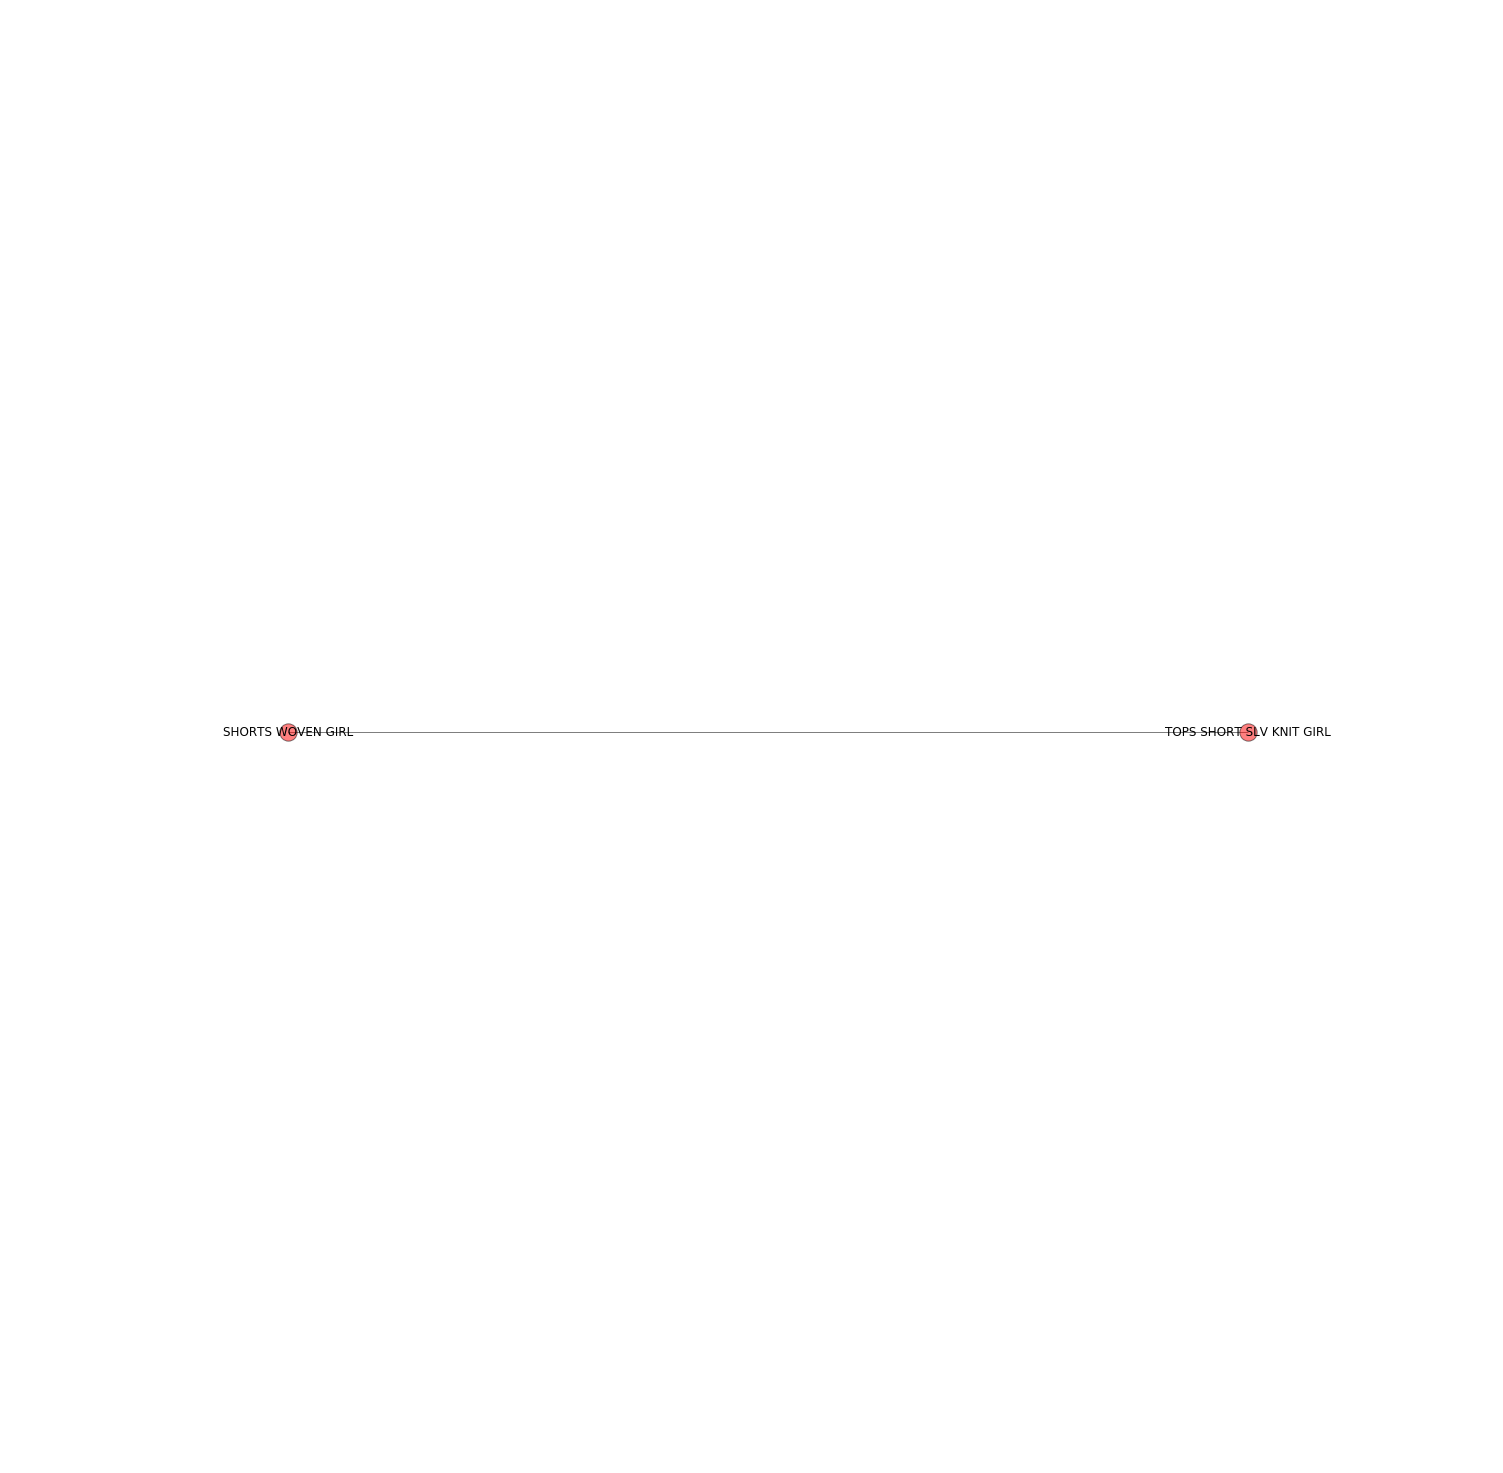

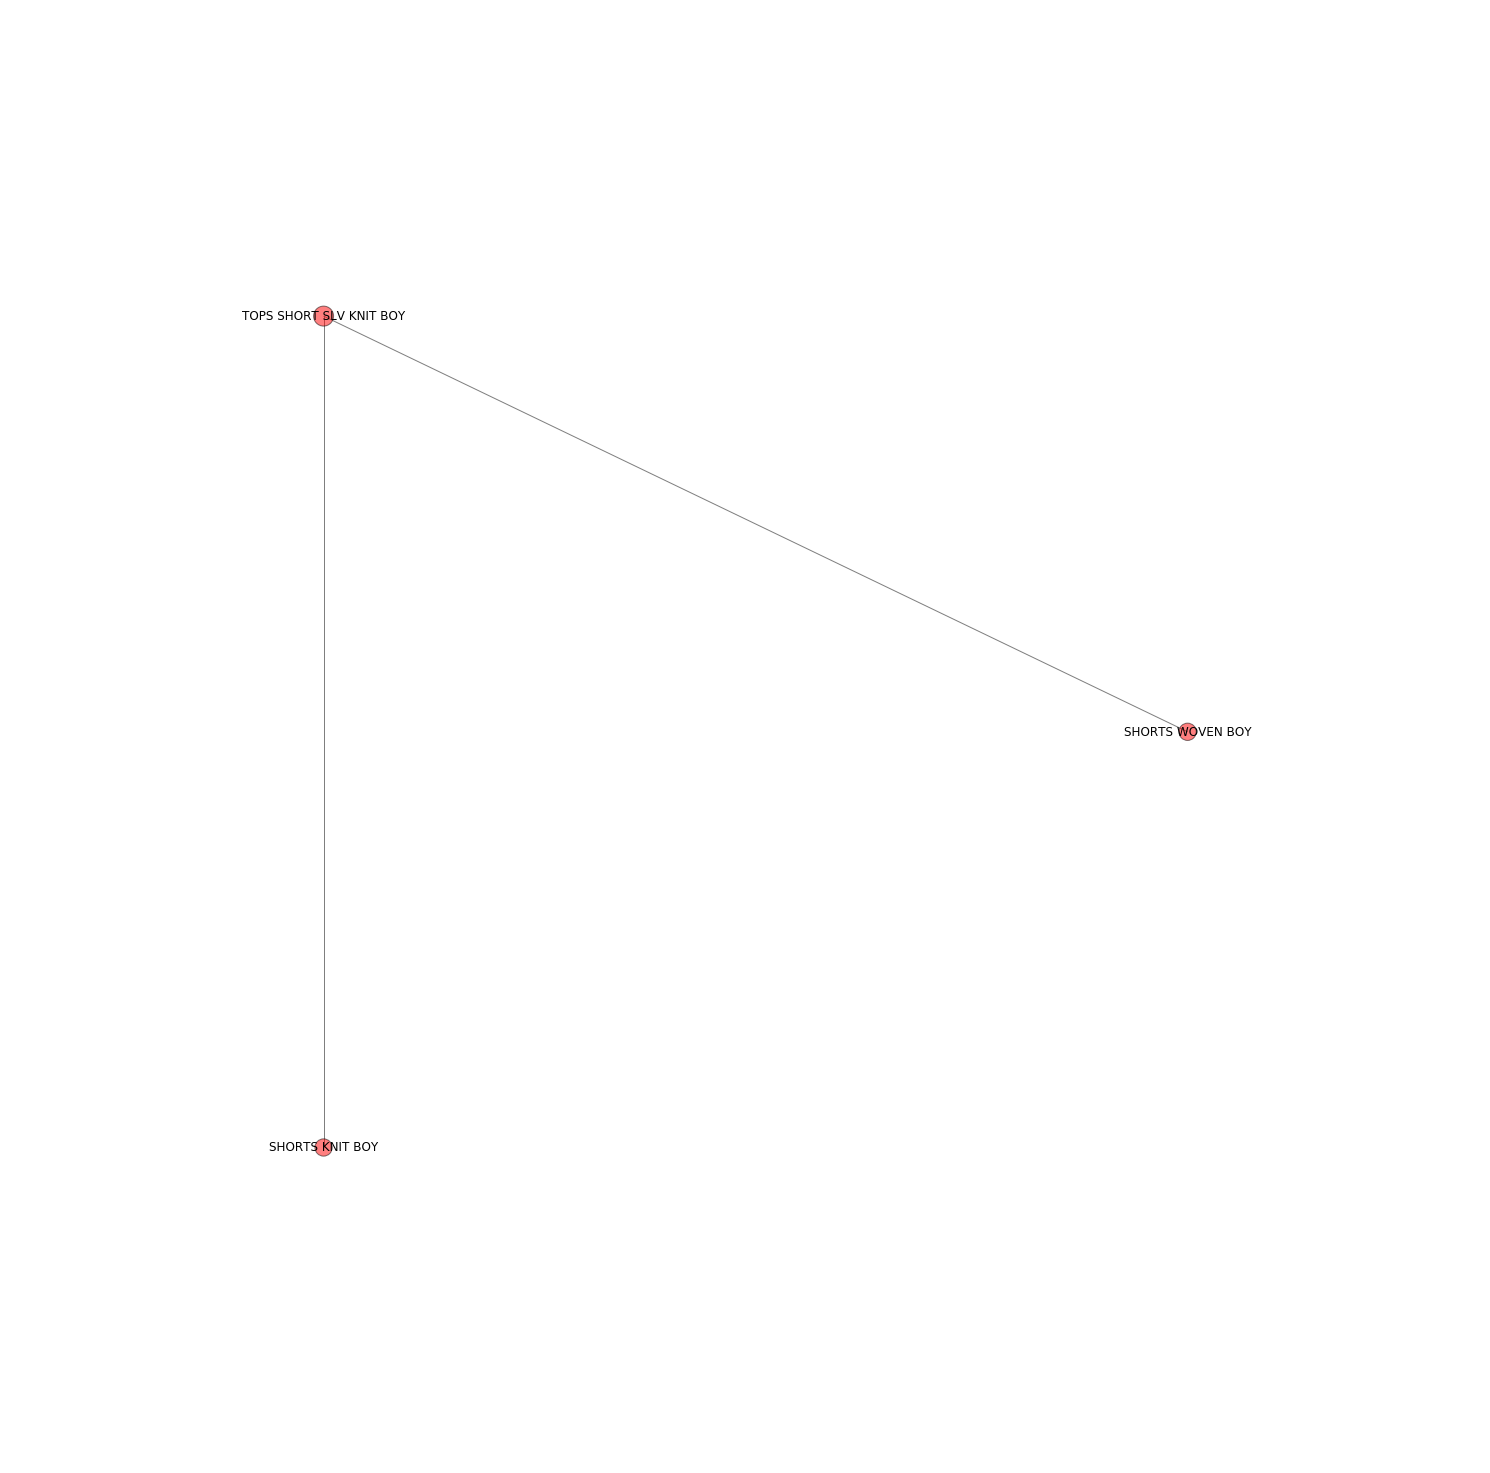

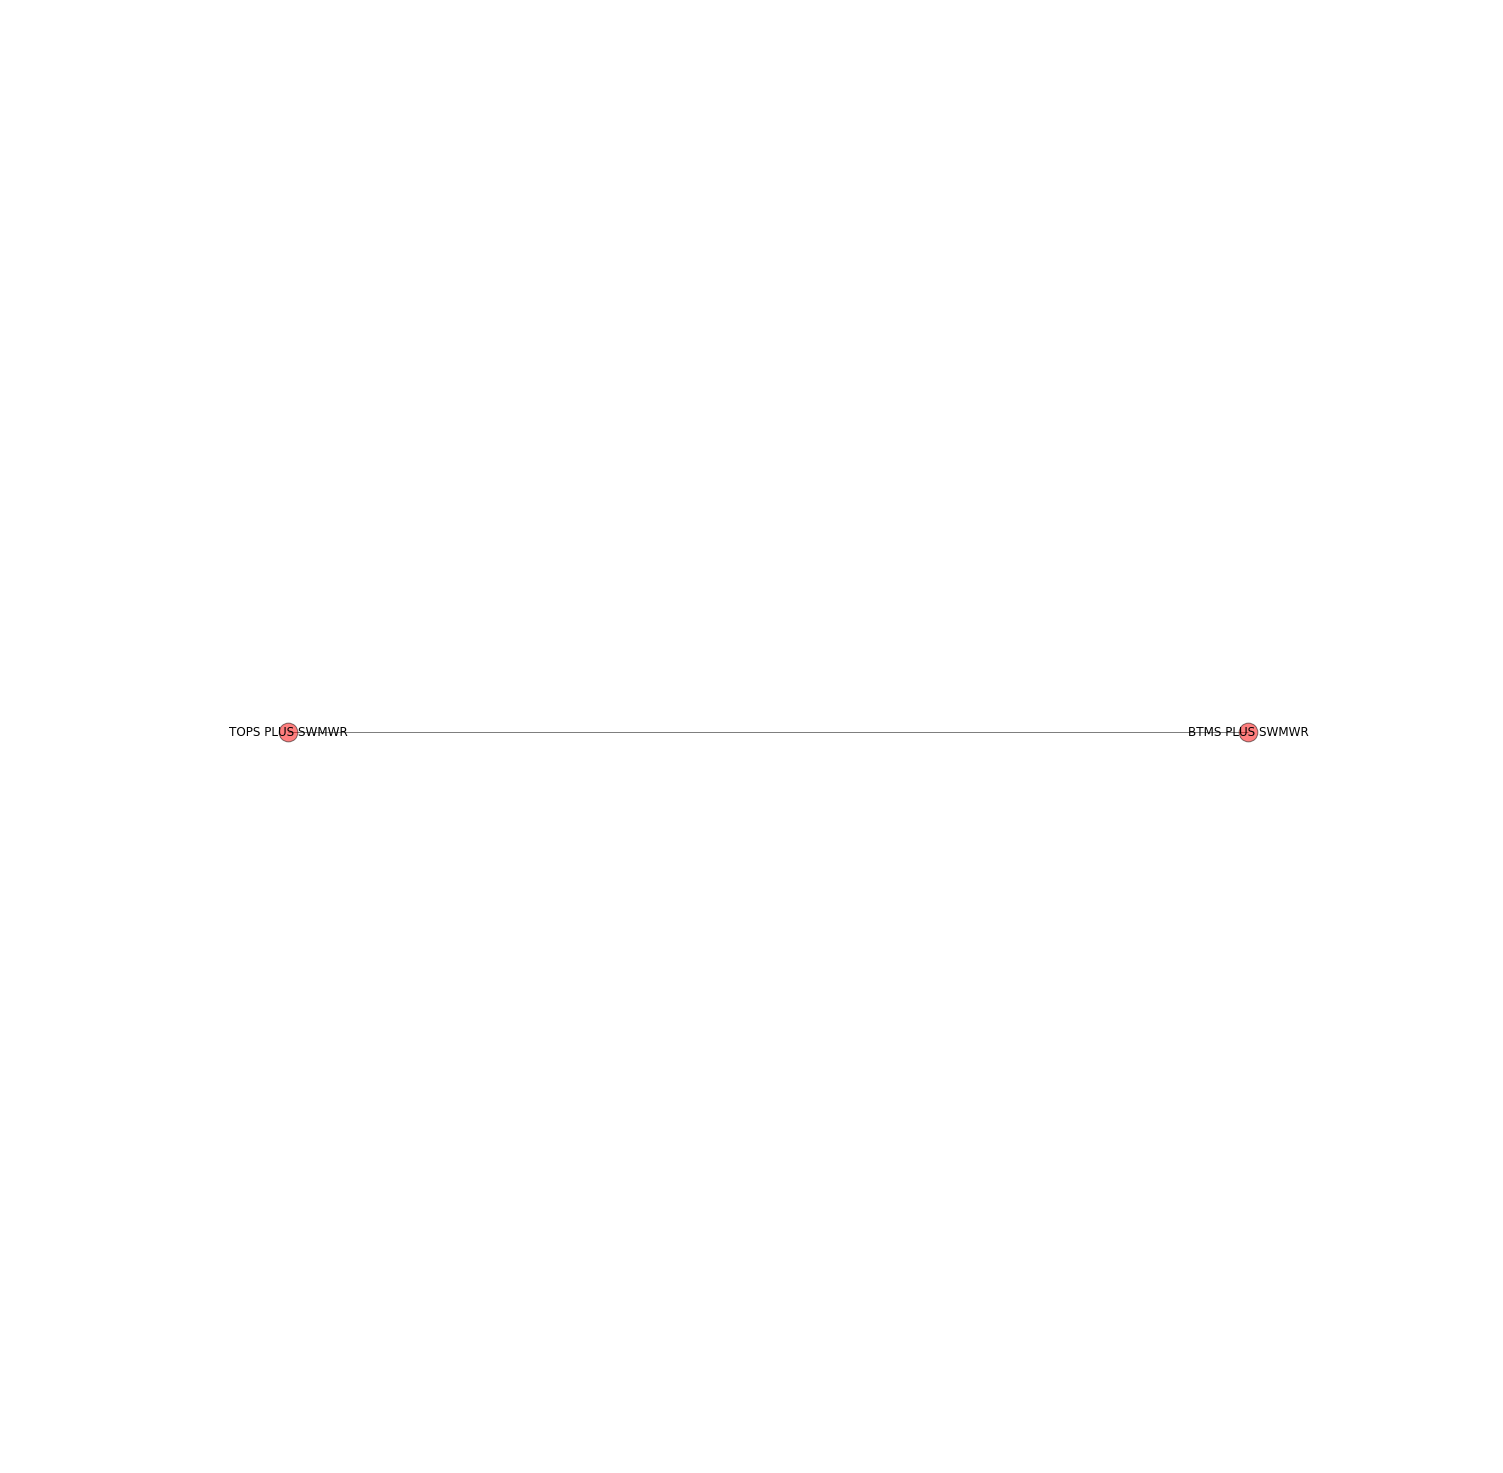

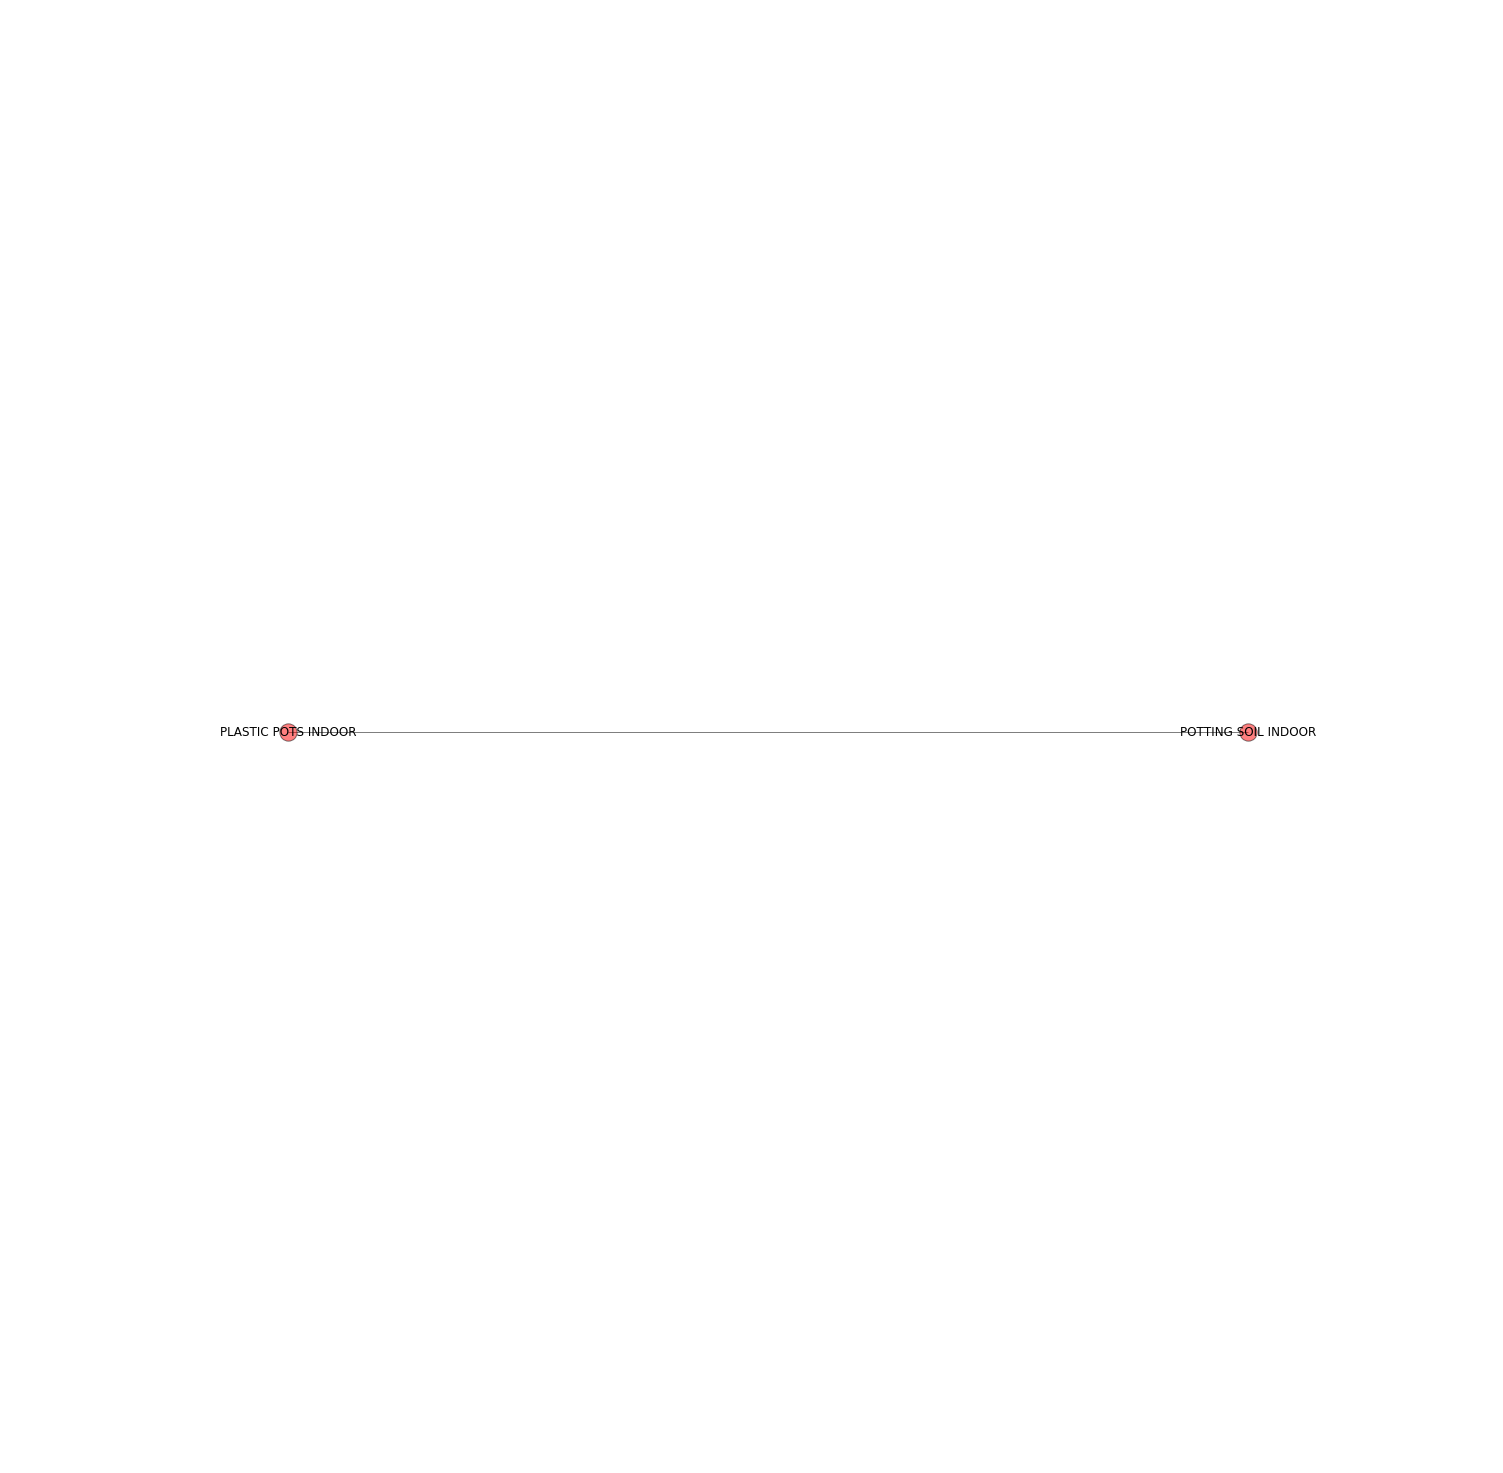

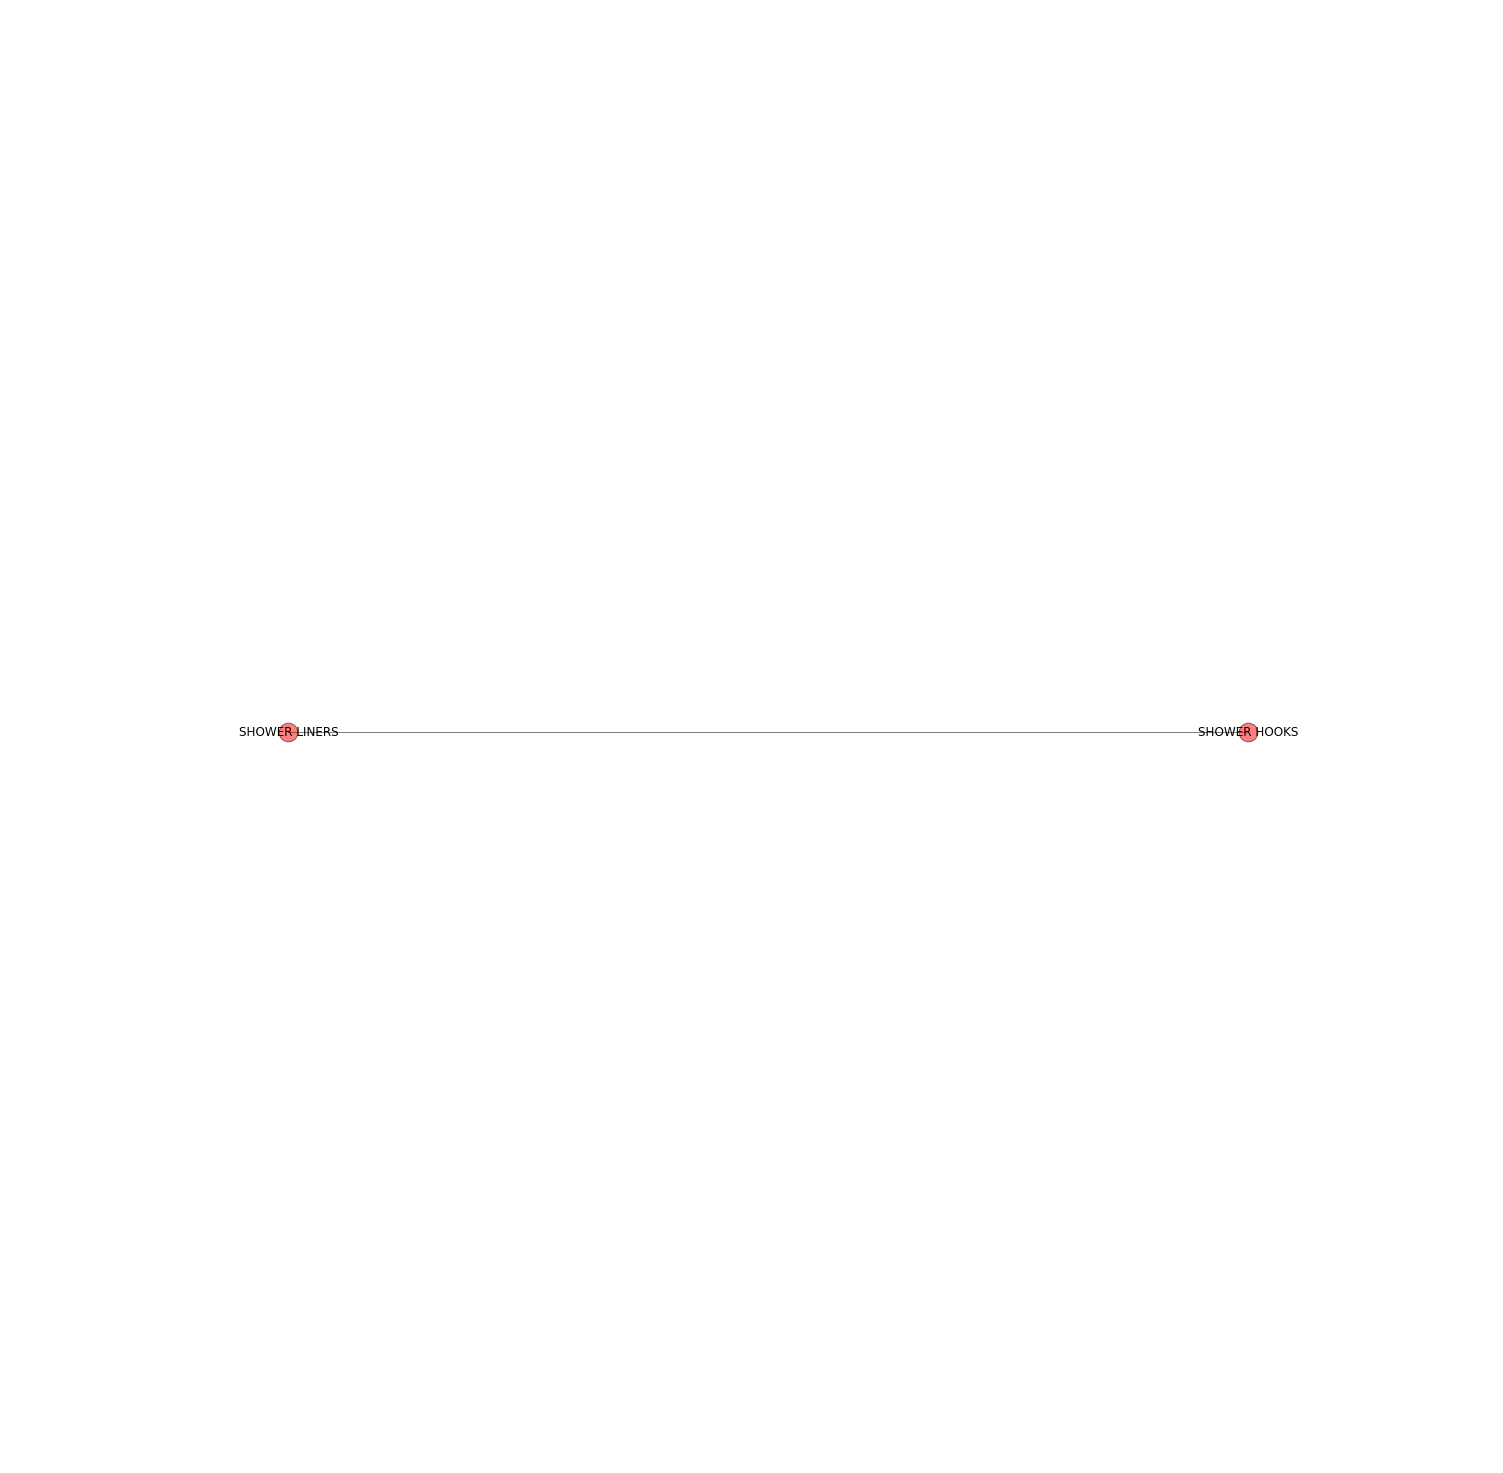

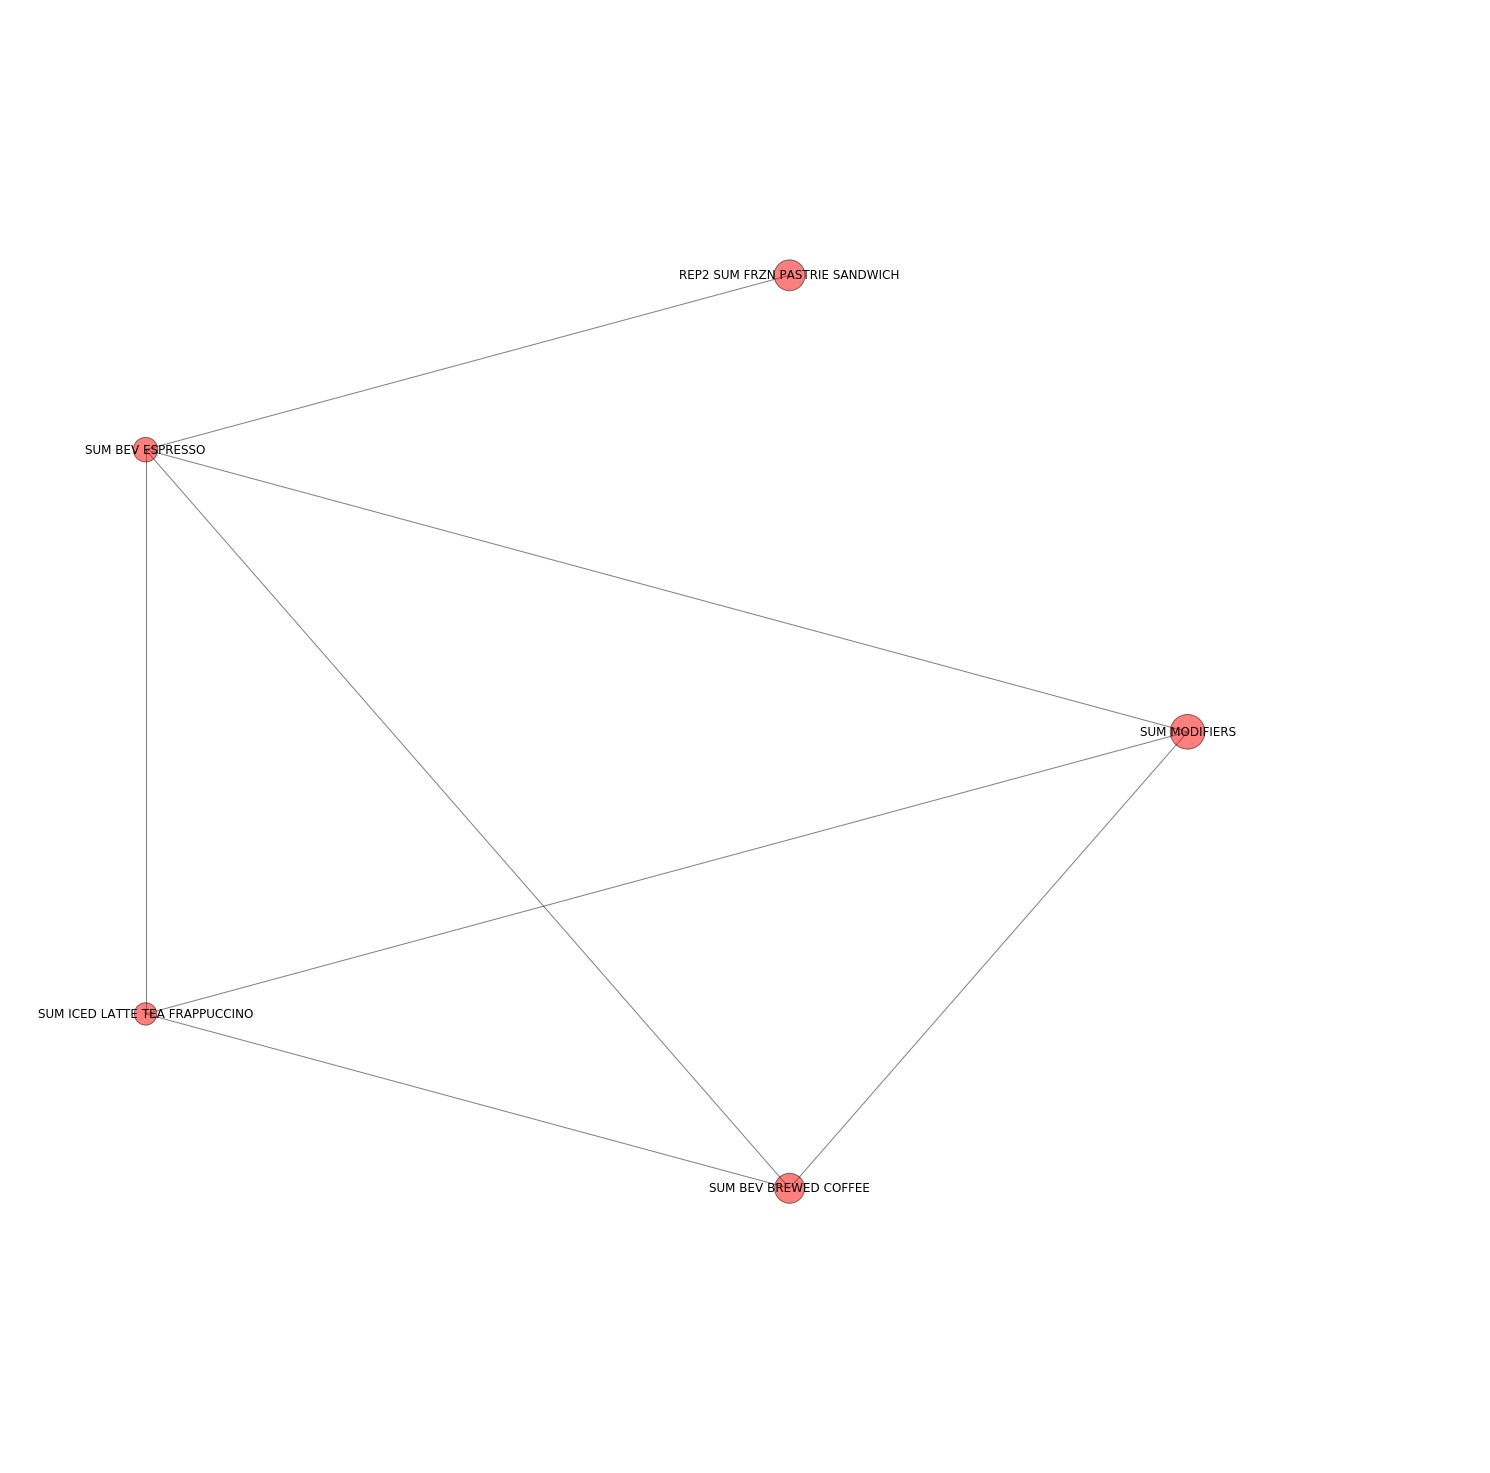

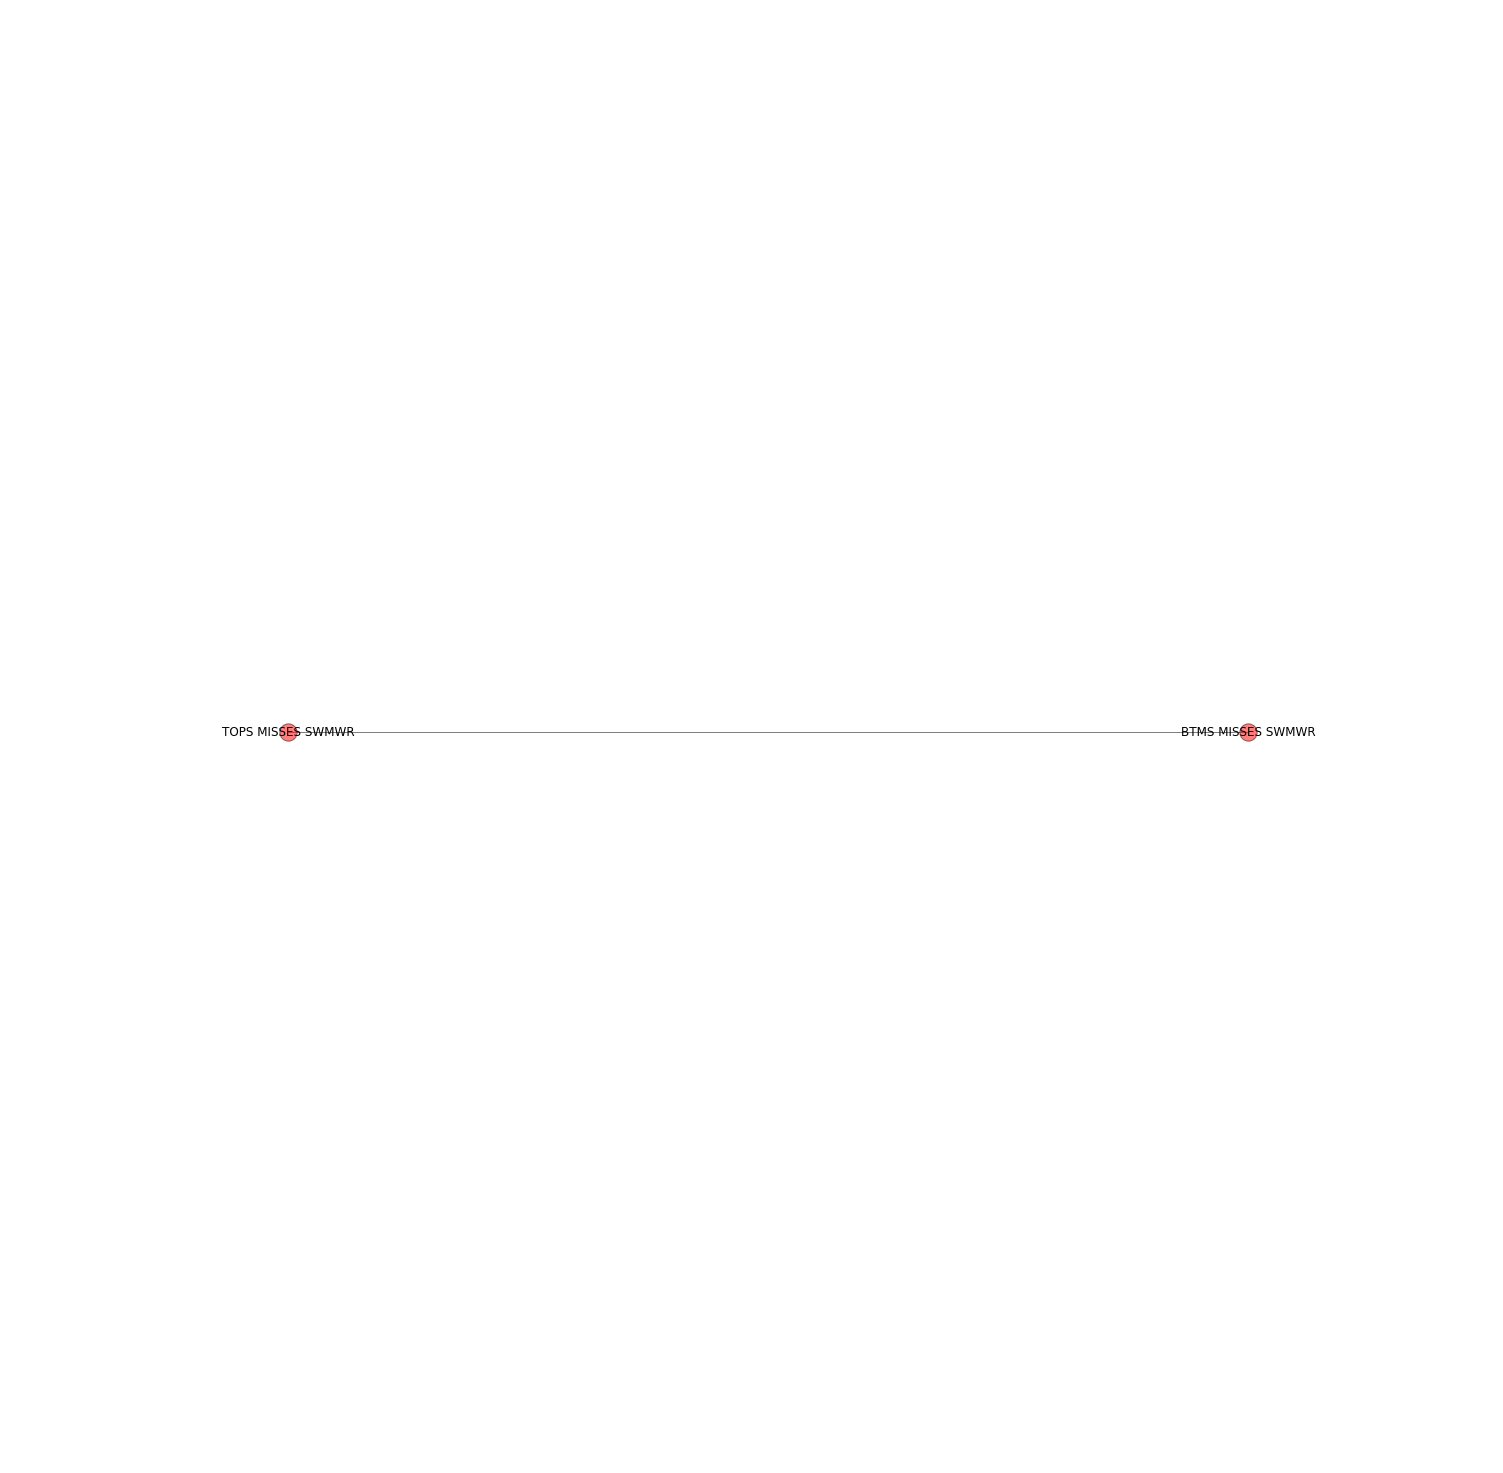

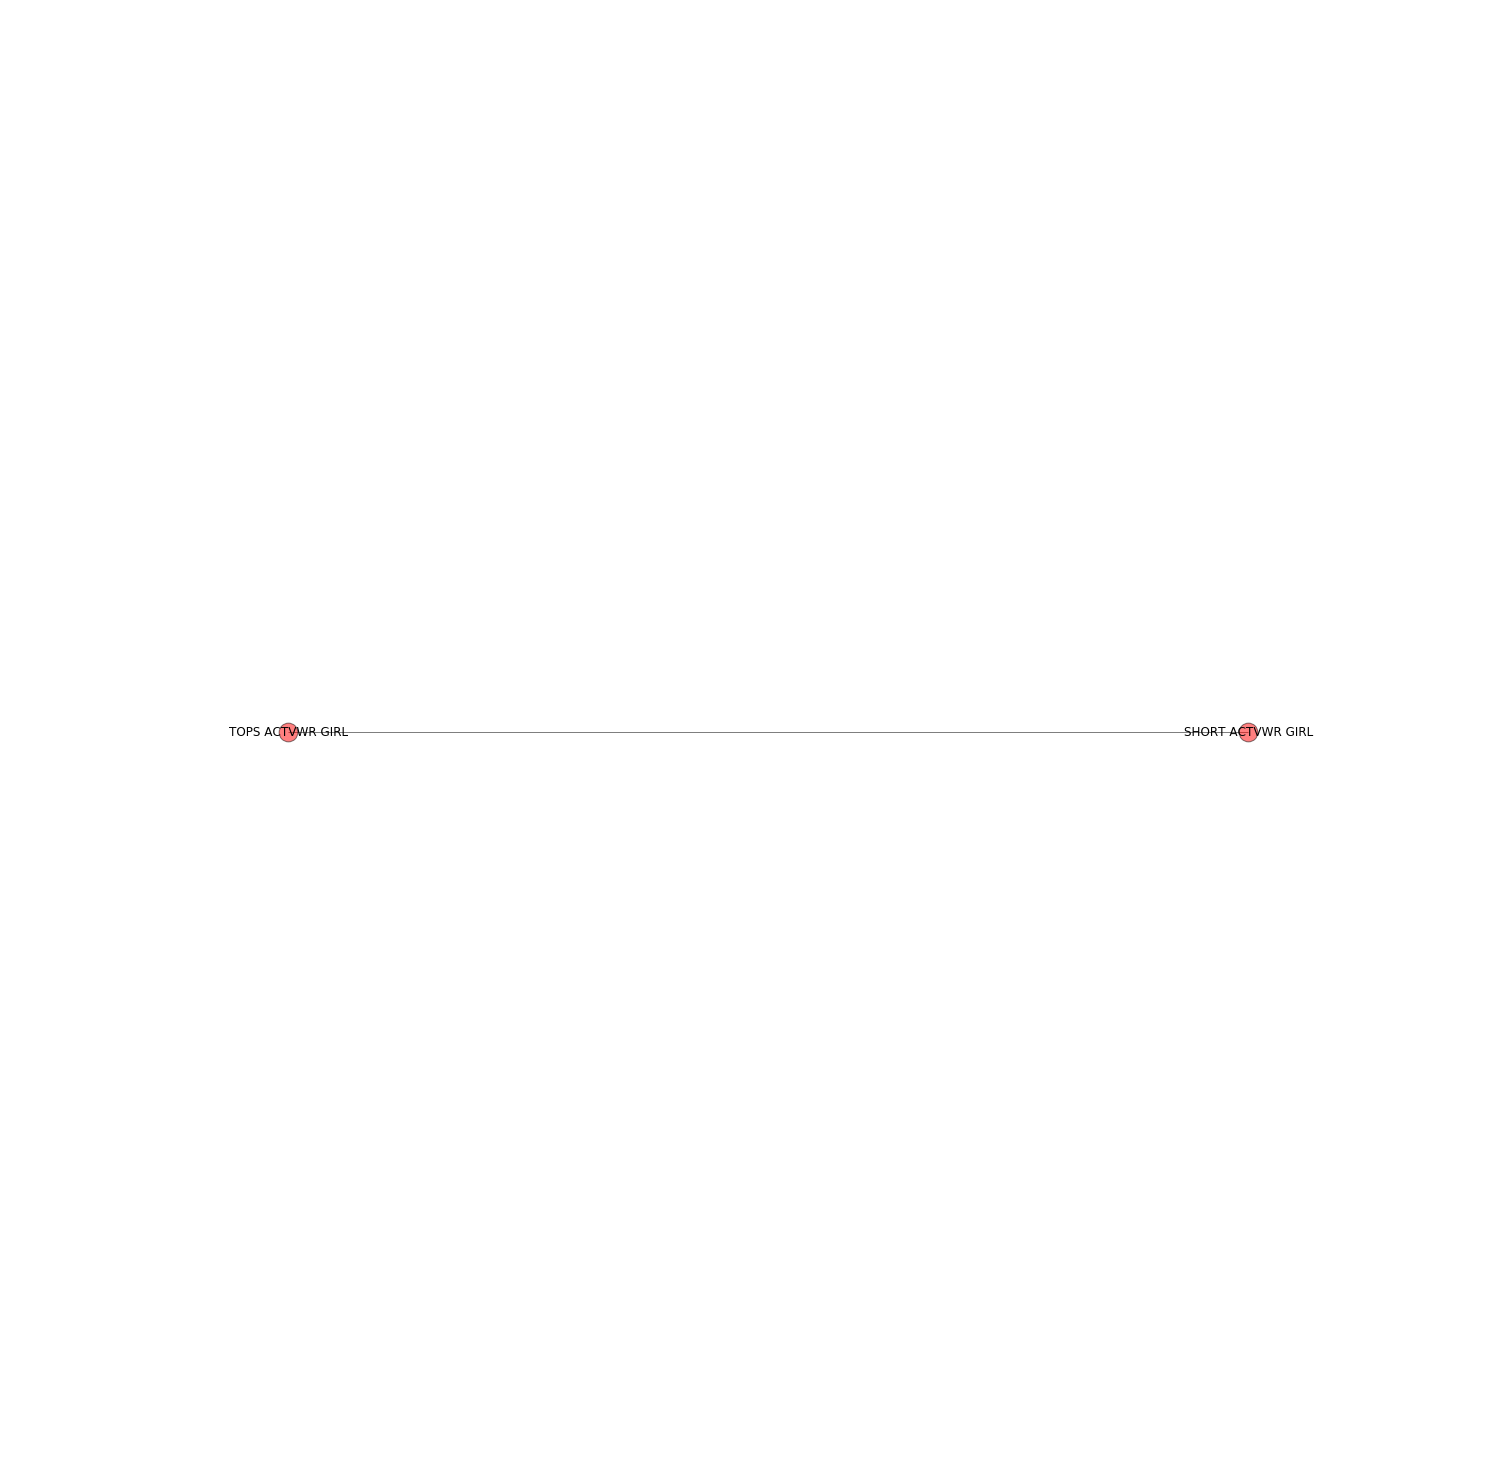

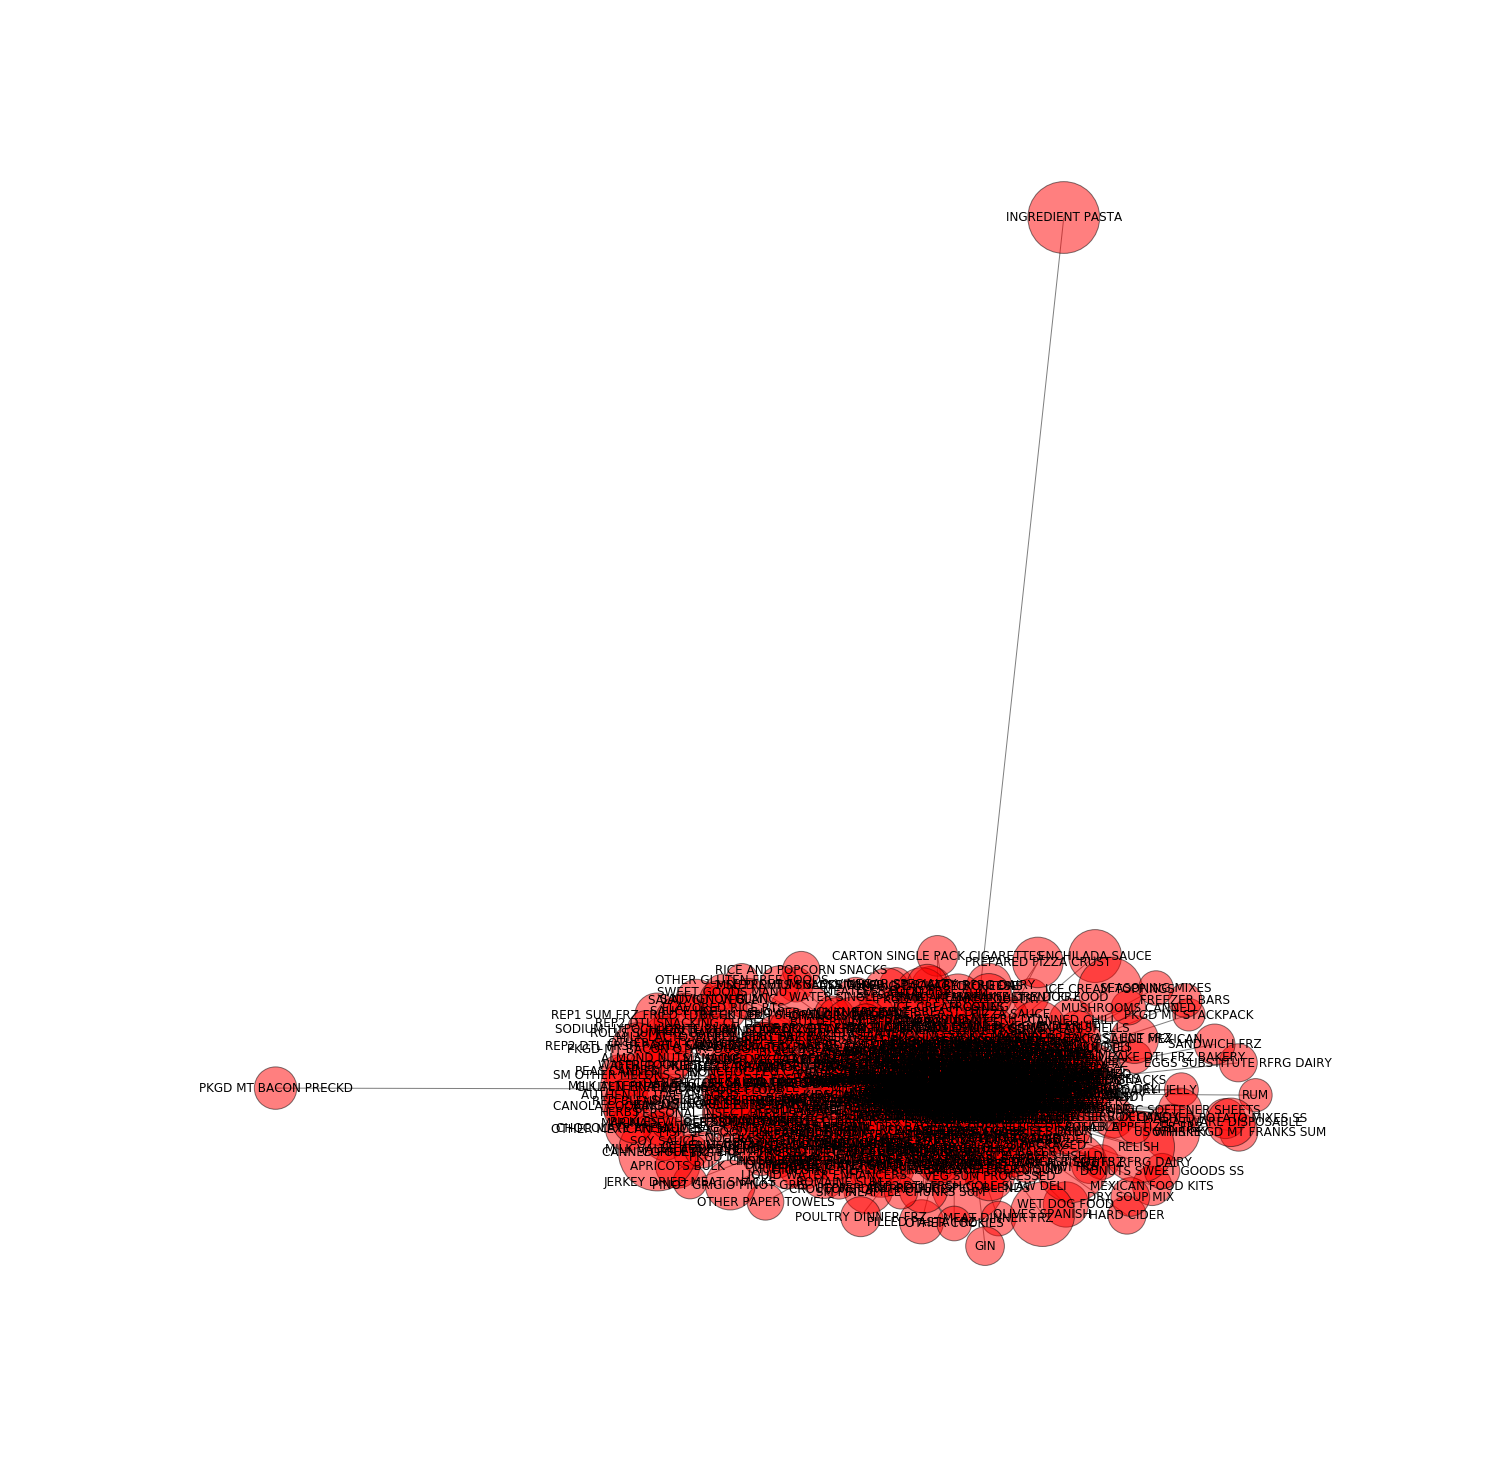

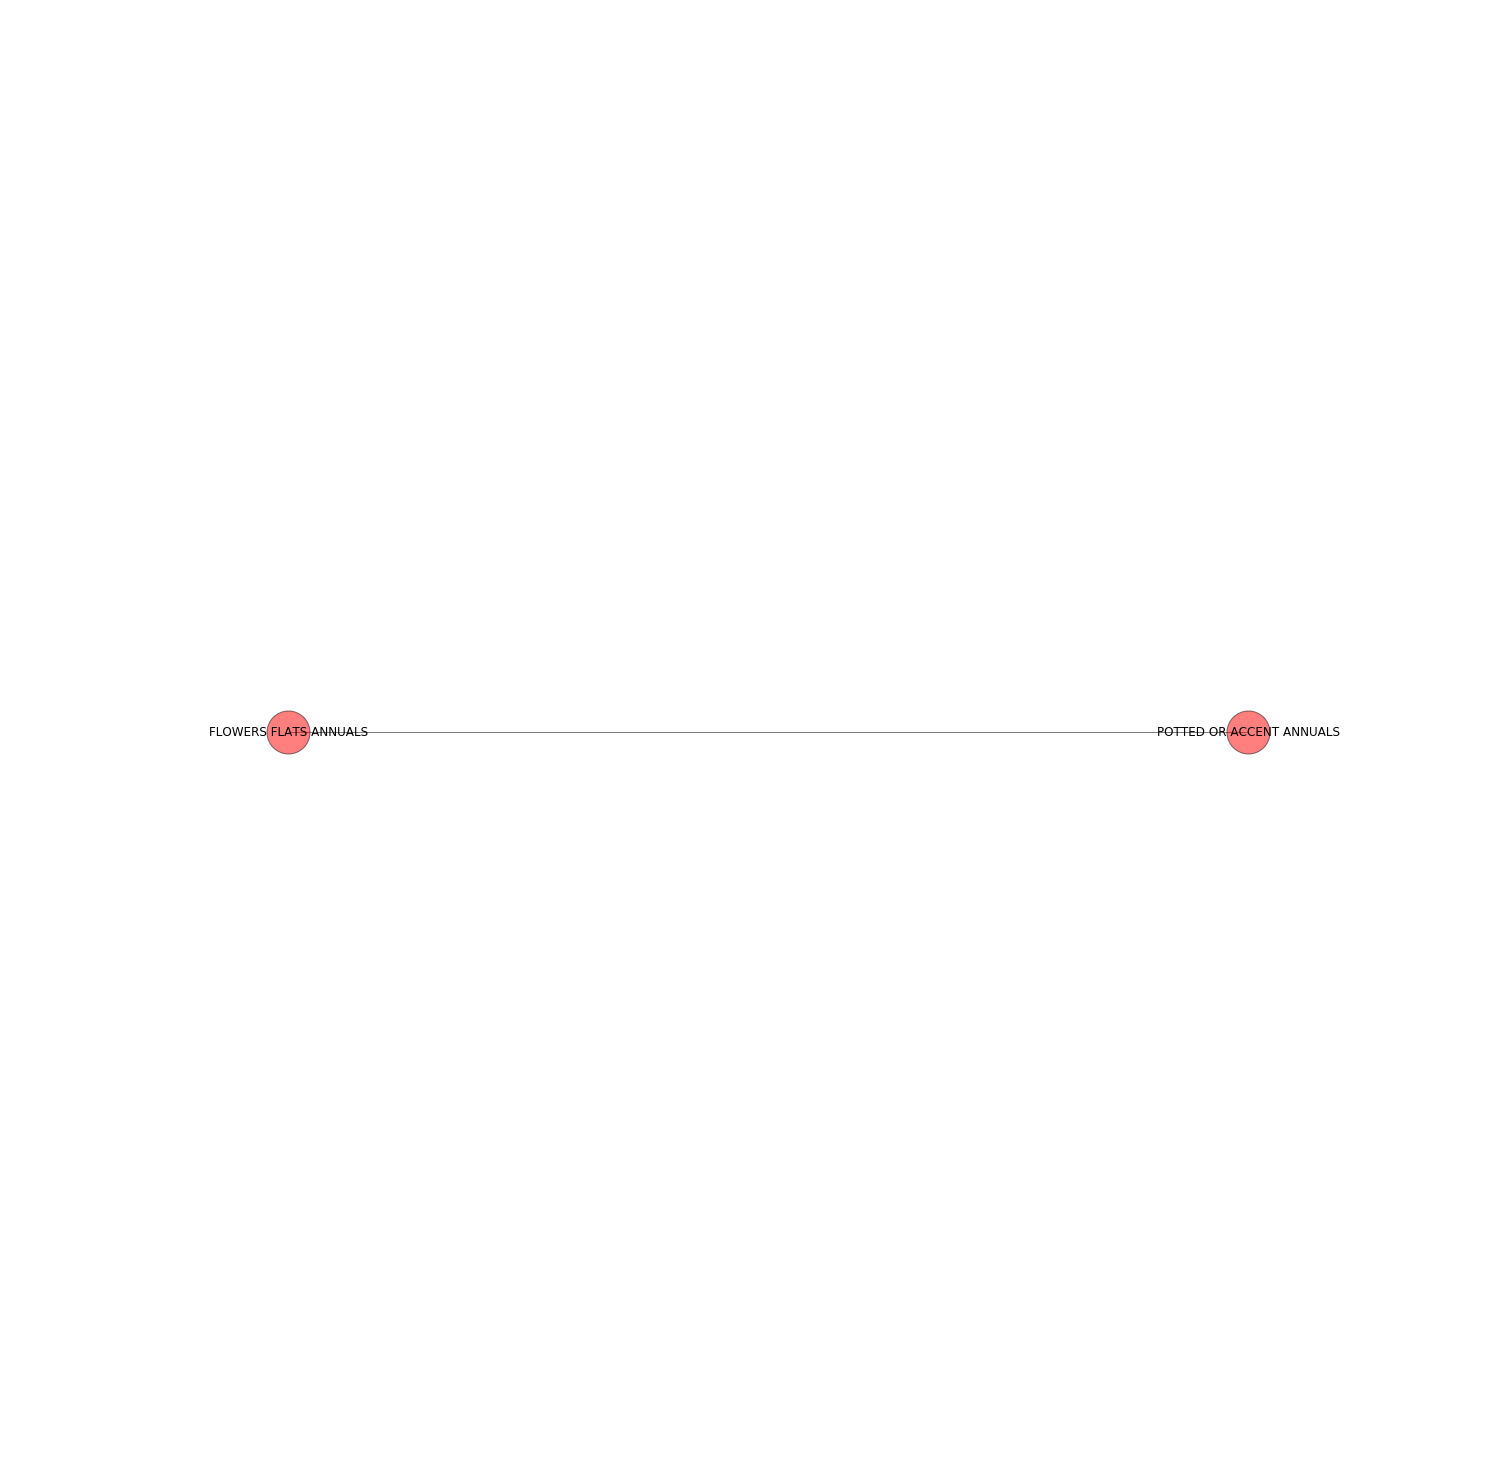

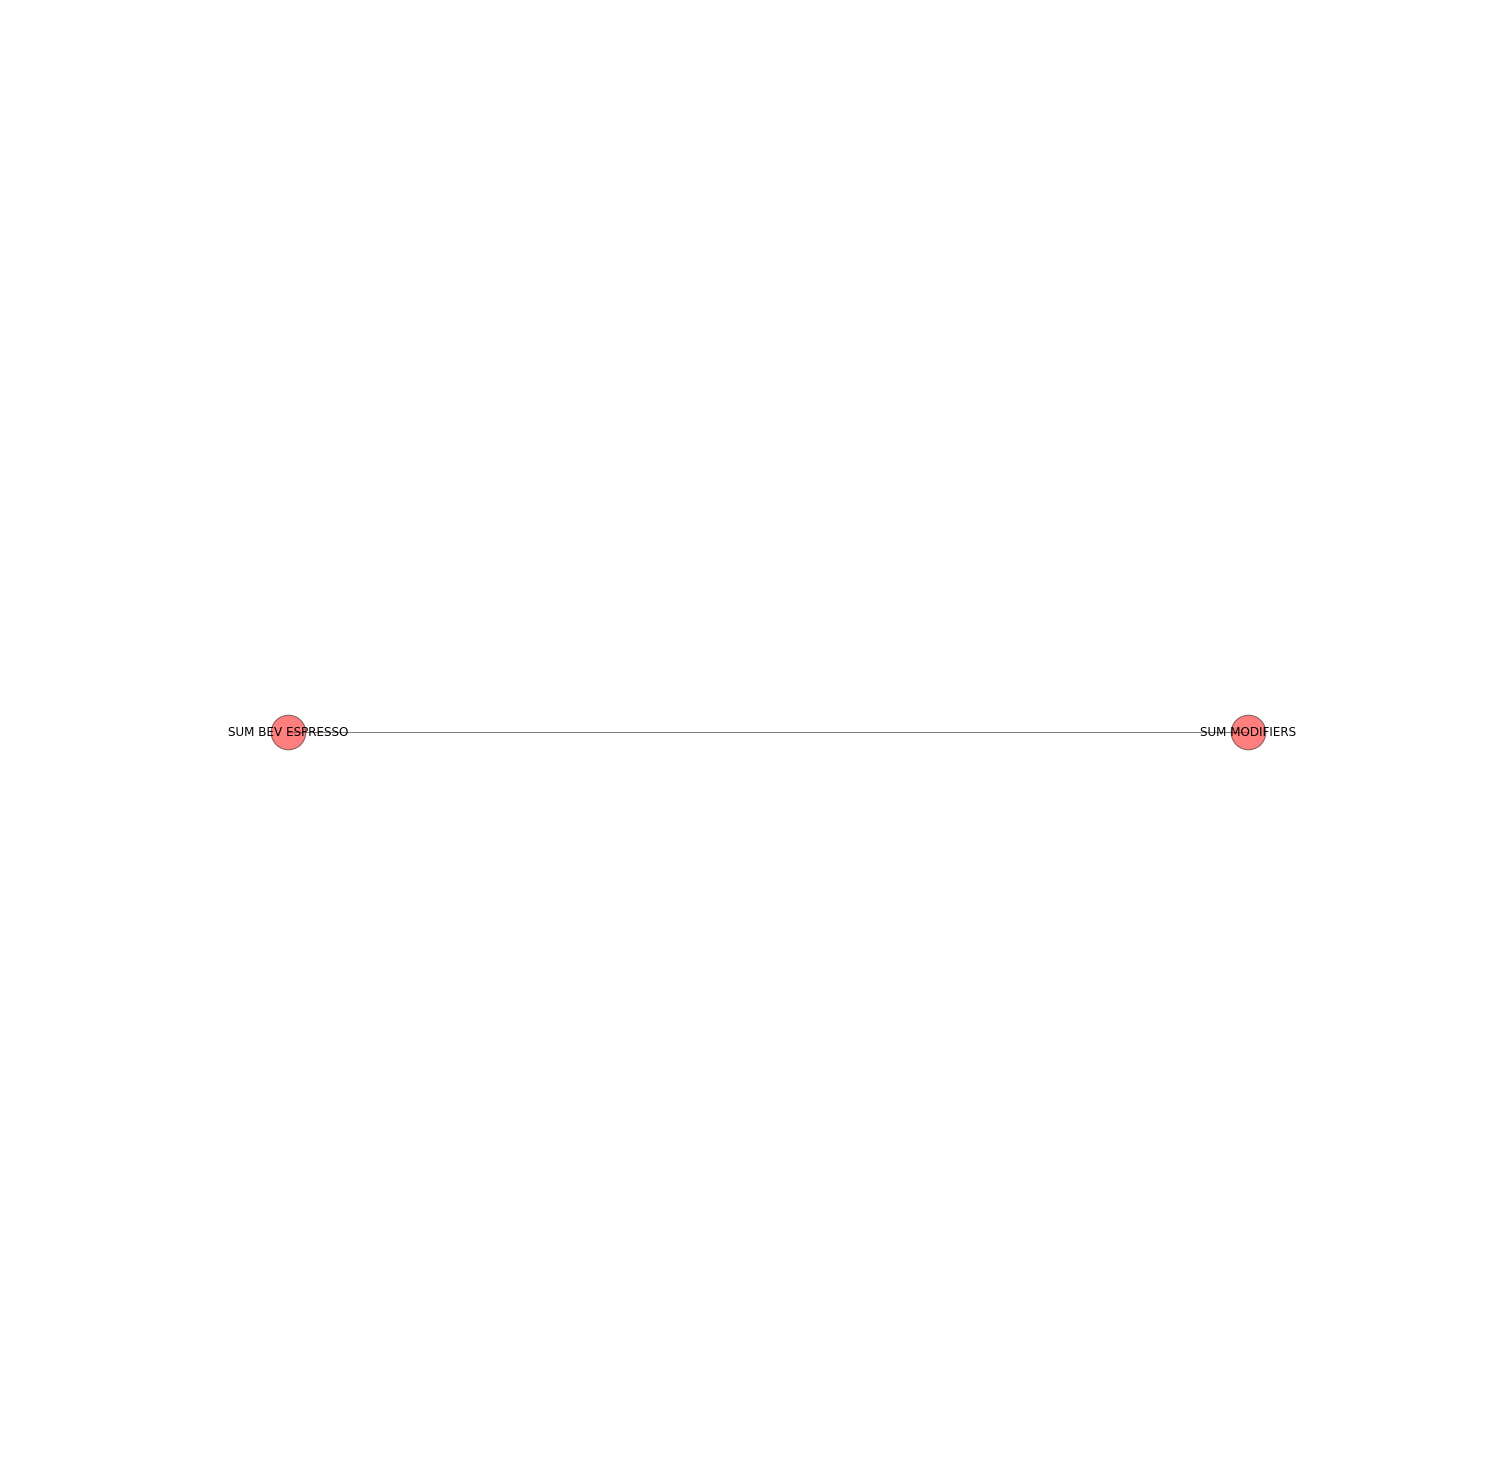

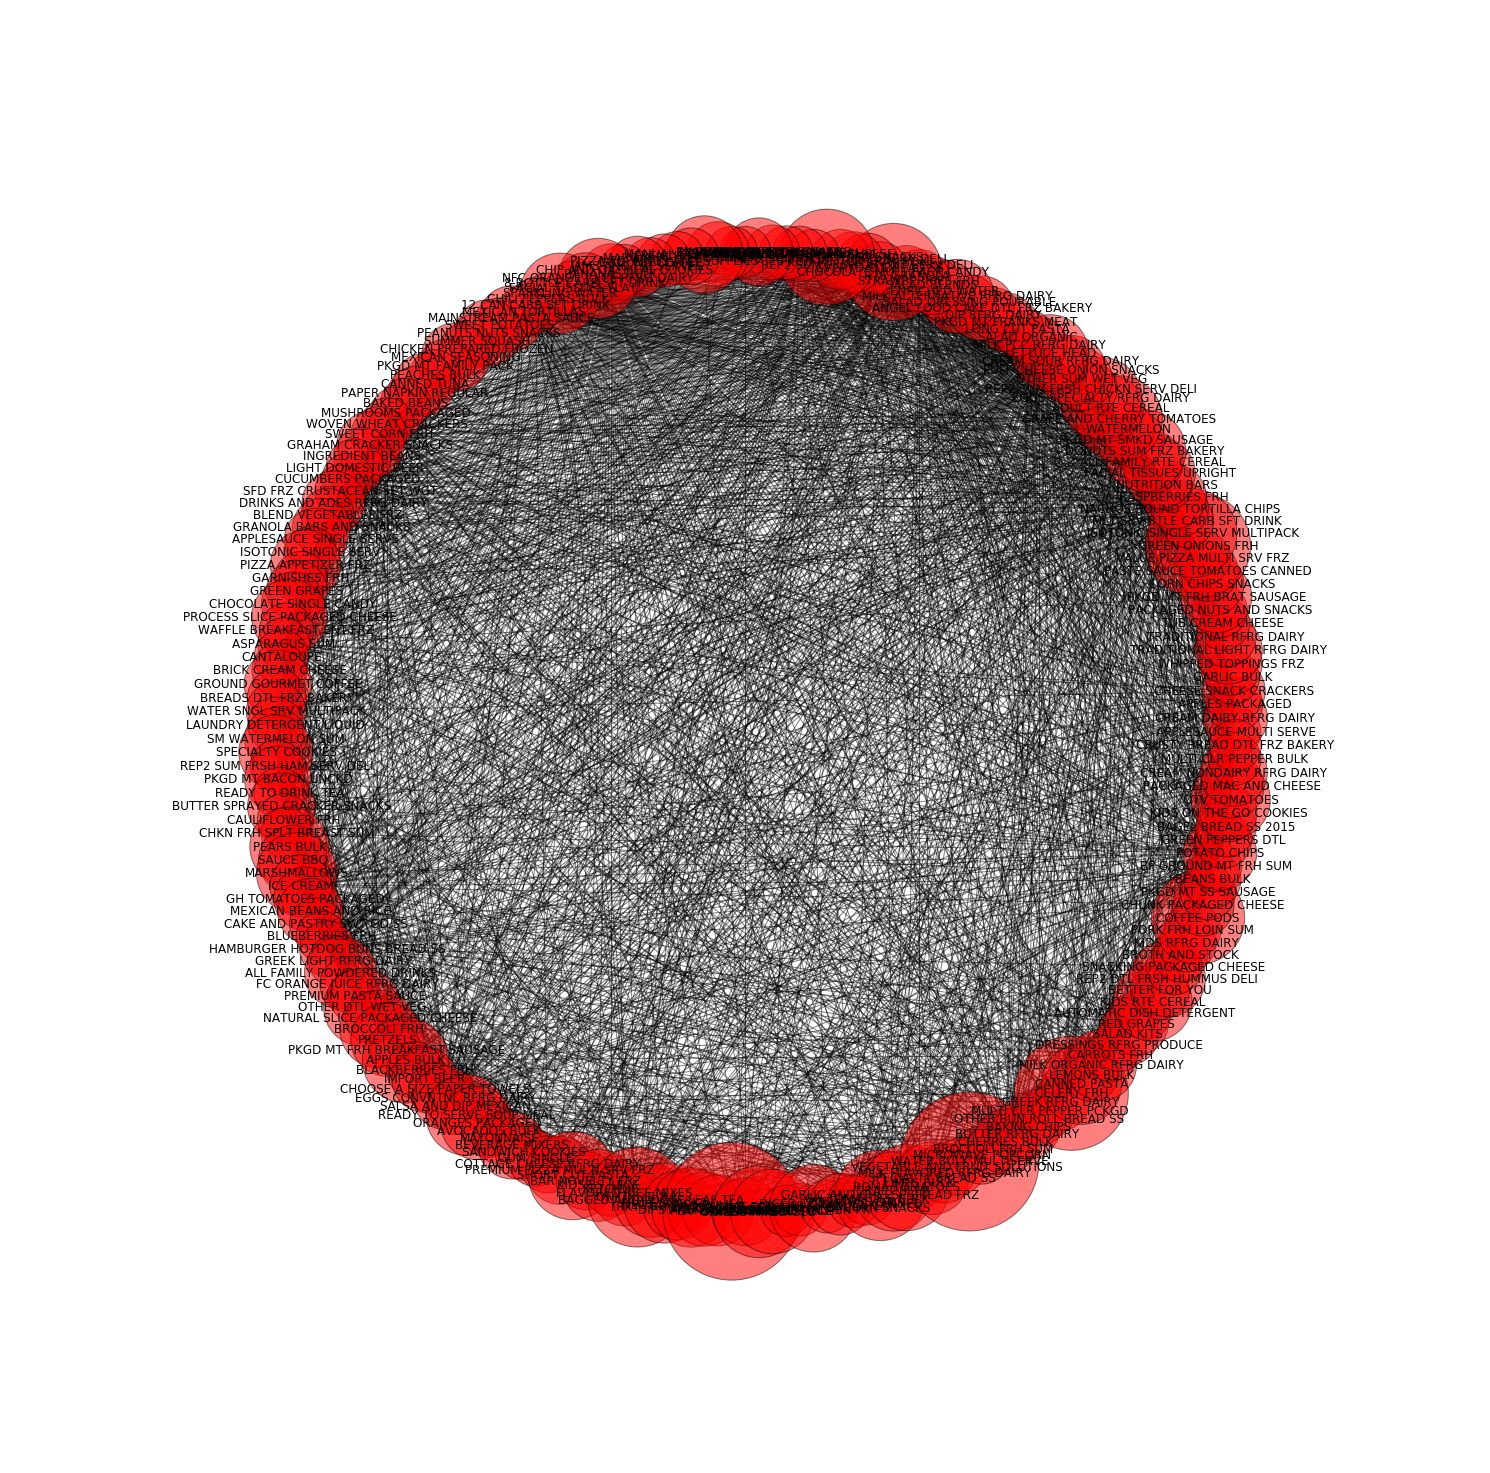

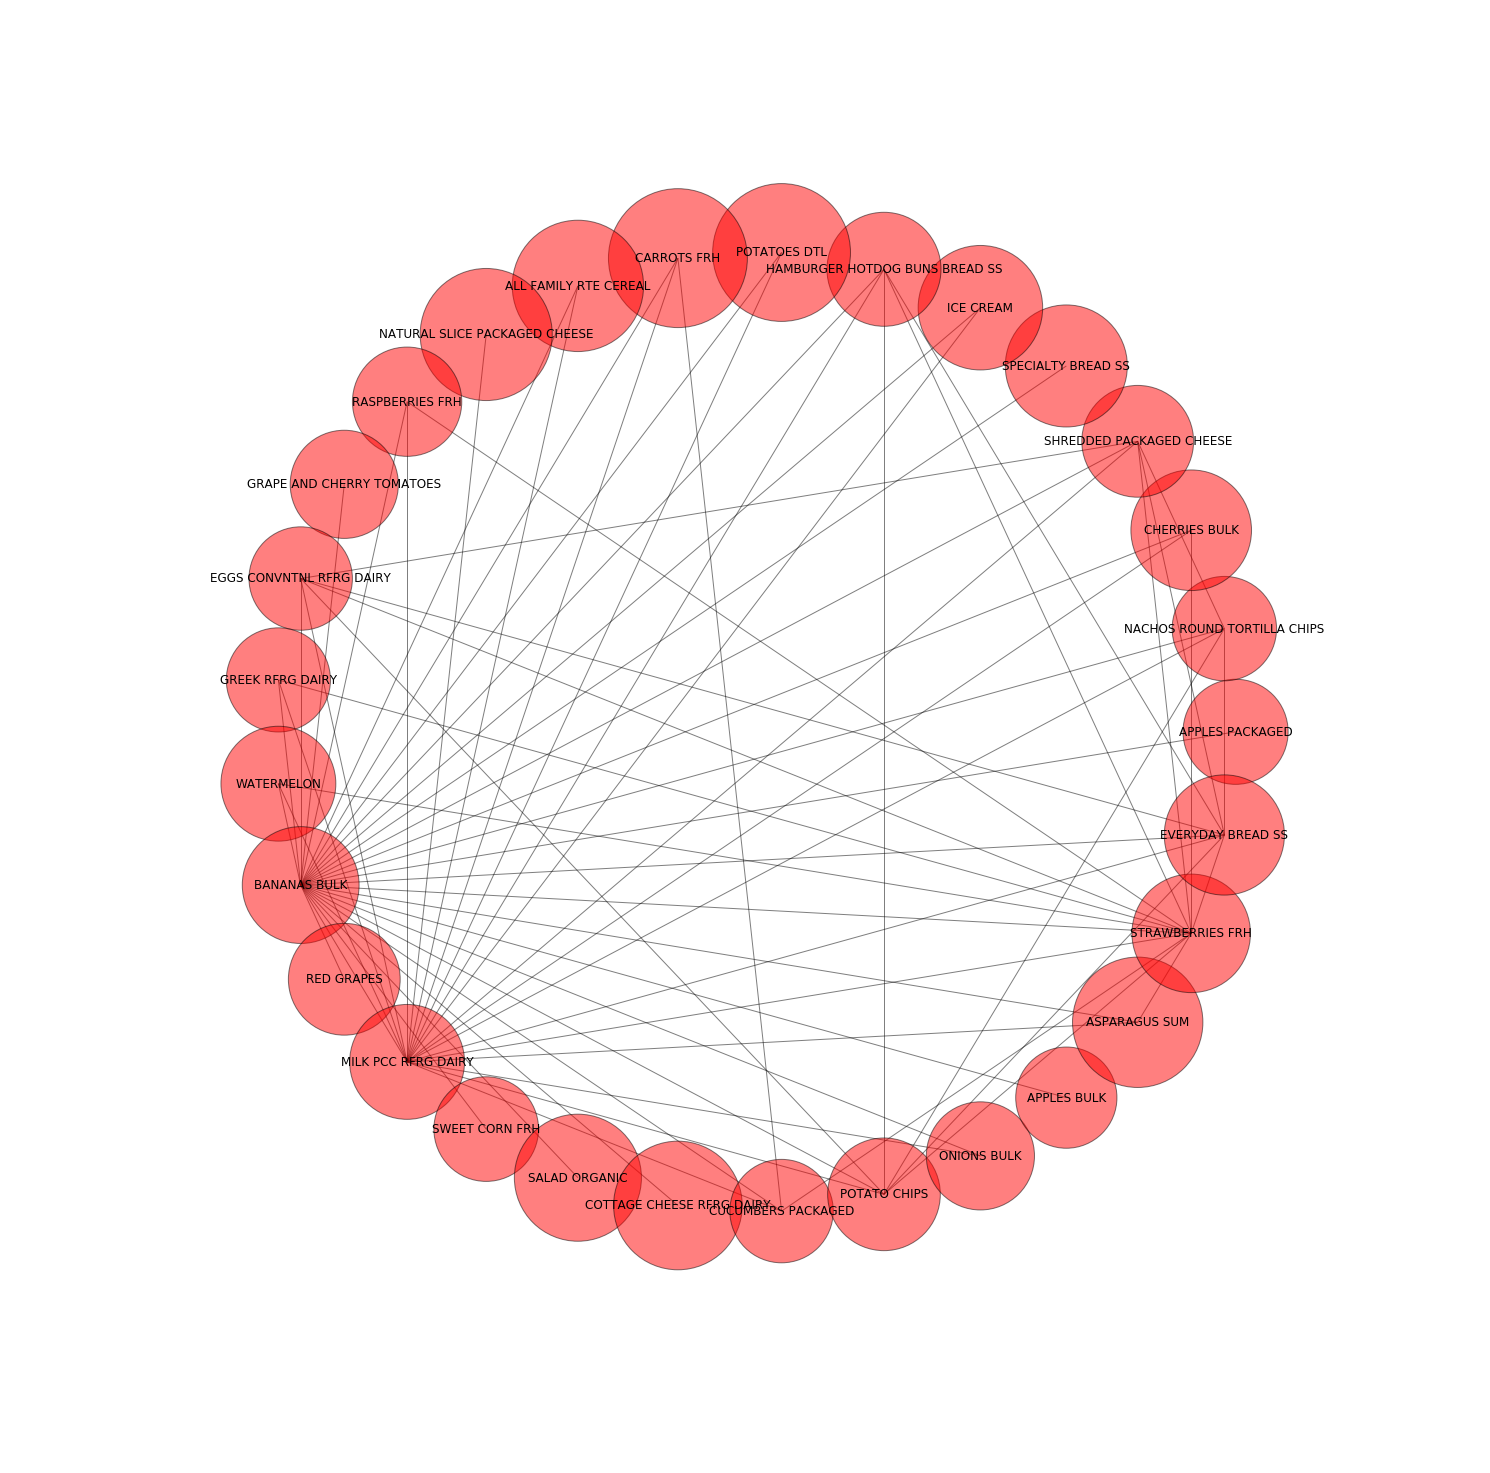

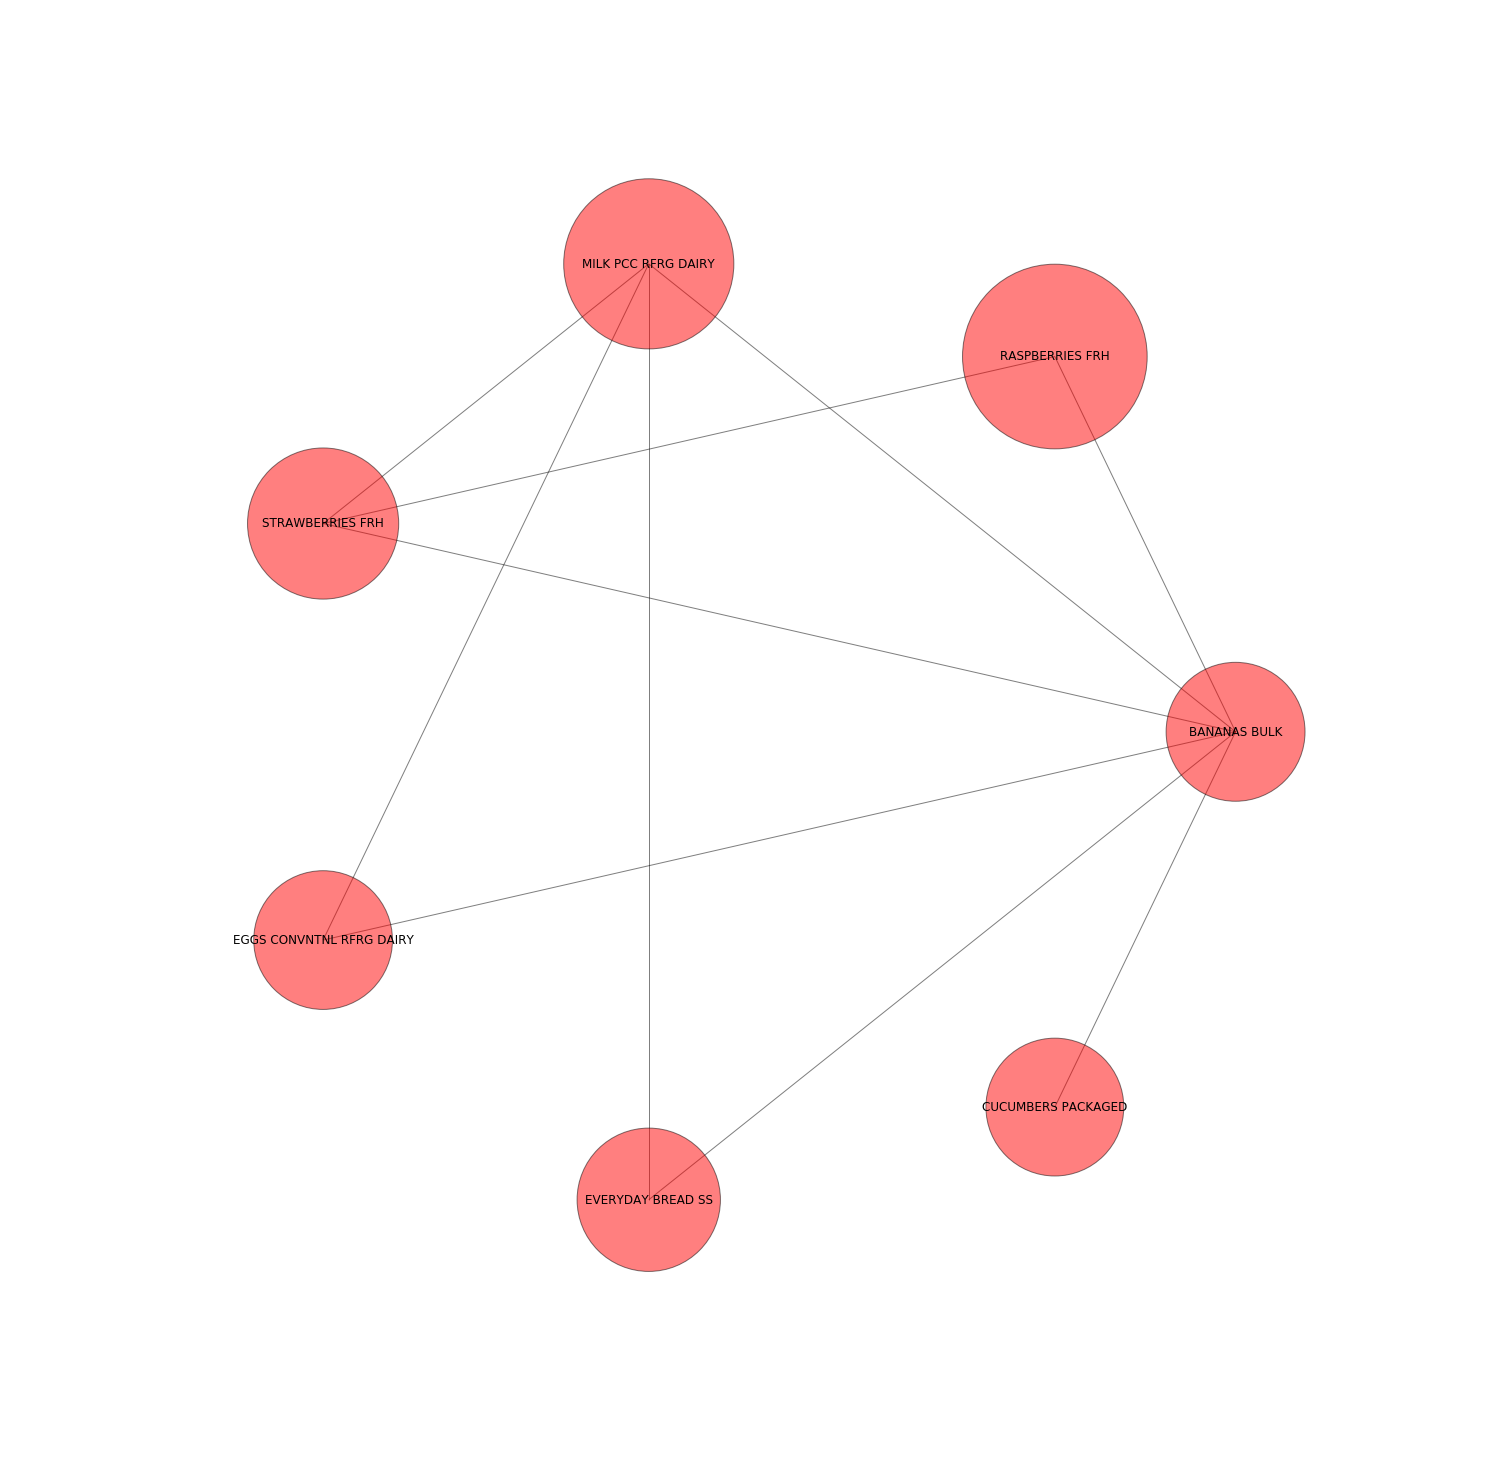

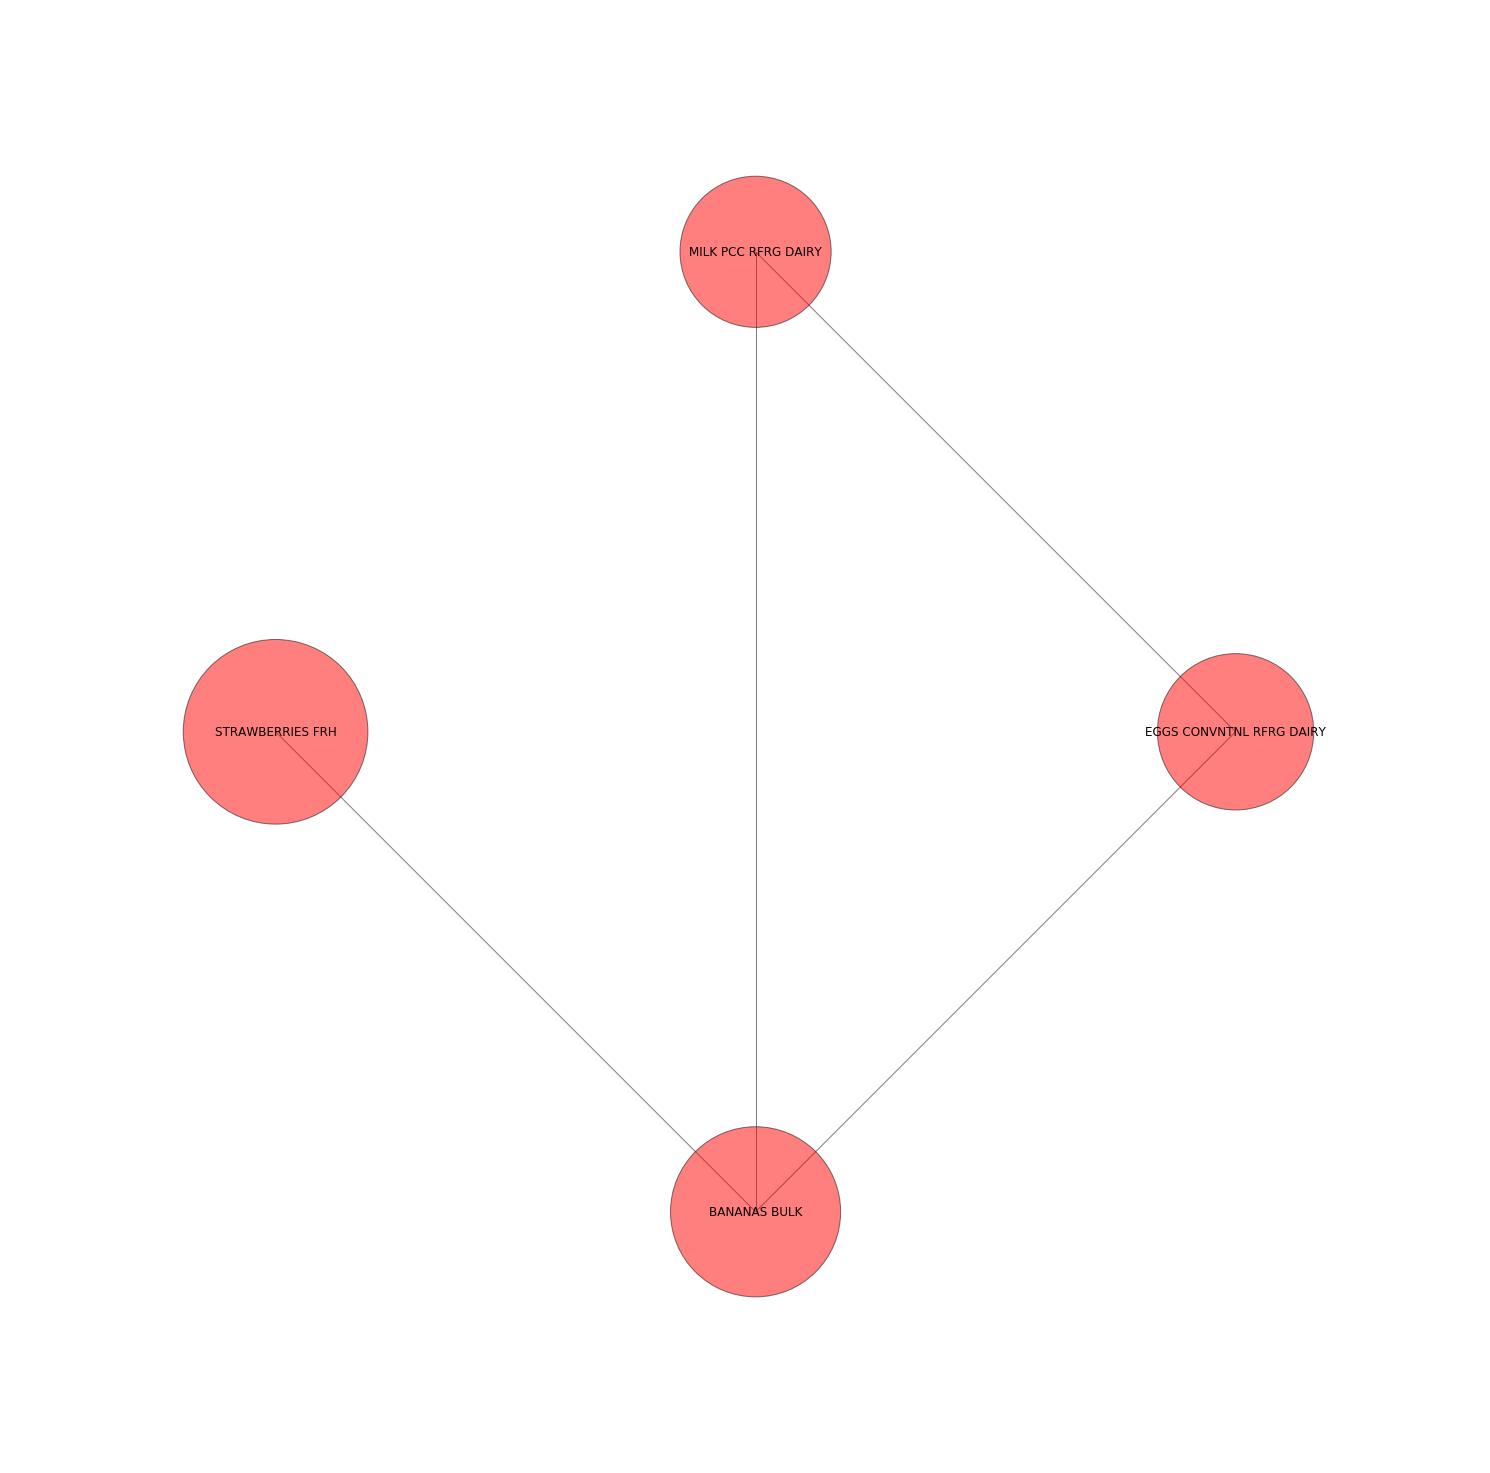

In [27]:
displayIslands(islands)

In [20]:
prod[prod.order_id.isin(prod[prod.product_desc=='ATHL SHOE BOY'].order_id.tolist())].sort_values(by='order_id')

order_id  product_id            product_desc  \
4215    11132214     2347473         KIDS RTE CEREAL   
96297   11132214      522110     ALL FAMILY SS JUICE   
94229   11132214      797626         NON-COFFEE PODS   
92382   11132214     1202760  FABRIC SOFTENER SHEETS   
87589   11132214     2704824  CONDENSED SOUP COOKING   
81742   11132214     3186371              US WHISKEY   
67794   11132214      445257         BEVERAGE MIXERS   
64852   11132214     2944654           ATHL SHOE BOY   
64601   11132214      345293    PAPER NAPKIN REGULAR   
123401  11132214     2767401    WILD BIRD MIXED SEED   
37266   11132214     1261023             COFFEE PODS   
16677   11132214      482179              SPRINKLERS   
41610   11132214     3428874        VODKA UNFLAVORED   
83554   11946400     2337289       REG FIT JEANS MEN   
53018   11946400     1847268        RUNNING SHOE MEN   
121031  11946400      690350     FACIAL TISSUES FLAT   
42844   11946400     2942776  BOXER BRIEF BOY UNDRWR   
66857   11946400     2944654           ATHL SHOE BOY   
72786   12704296      432629                HAMMOCKS   
66811   12704296     2525275             SKIRTS GIRL   
33219   12704296     1906278        TOPS ACTVWR GIRL   
64880   12704296     2942776  BOXER BRIEF BOY UNDRWR   
101721  12704296     1421993  LWCT NO SHOW SOCK GIRL   
104186  12704296     2944654           ATHL SHOE BOY   
55225   12961566     2168659       NONCHOC BAG CANDY   
30671   12961566      660709     PIZZA APPETIZER FRZ   
107861  12961566      537614     POCKET SANDWICH FRZ   
110770  12961566     2944654           ATHL SHOE BOY   

                             cat_desc  
4215              READY TO EAT CEREAL  
96297      JUICES AND JUICE DRINKS SS  
94229                     COFFEE PODS  
92382                 FABRIC SOFTENER  
87589                  CONDENSED SOUP  
81742                         WHISKEY  
67794                 BEVERAGE MIXERS  
64852                   KIDS ATHLETIC  
64601                    PAPER NAPKIN  
123401      WILDBIRD FEEDERS AND FOOD  
37266                     COFFEE PODS  
16677     GARDEN HOSES AND SPRINKLERS  
41610                           VODKA  
83554                      JEANS MENS  
53018              RUNNING SHOES MENS  
121031                 FACIAL TISSUES  
42844                  KIDS UNDERWEAR  
66857                   KIDS ATHLETIC  
72786   OUTDOOR FURNITURE ACCESSORIES  
66811                   BOTTOMS GIRLS  
33219                ACTIVEWEAR GIRLS  
64880                  KIDS UNDERWEAR  
101721                     KIDS SOCKS  
104186                  KIDS ATHLETIC  
55225              CANDY NONCHOCOLATE  
30671                FROZEN APPETIZER  
107861                FROZEN SANDWICH  
110770                  KIDS ATHLETIC

In [21]:
prod[prod.order_id.isin(prod[prod.product_desc=='PLATES DINNER'].order_id.tolist())].sort_values(by='order_id')

order_id  product_id                   product_desc  \
31513   11388431      156462  REP2 DTL CHEDDAR SPEC CH DELI   
31826   11388431     2900642  REP2 DTL FRSH DRY MT PRS DELI   
39764   11388431      358673         GADGETS SERVING PIECES   
49129   11388431      571878                  PLATES DINNER   
55575   11388431     2196361                     CRAFT BEER   
66918   11388431     2777011               MULTI PACKS BATH   
77928   11388431     1564058         BOWLS SMALL INDIVIDUAL   
1091    11575709      982805         TABLE LINENS PLACEMATS   
9078    11575709     1563828          SUMMER PLACE SETTINGS   
9079    11575709     2411779                  LEGGINGS GIRL   
12049   11575709      950883        LIGHTING RPLCMNT SHADES   
17808   11575709     1702777                   TOILET PAPER   
25798   11575709      571878                  PLATES DINNER   
64610   11575709      890818                       DOG TOYS   
101270  11575709     1564058         BOWLS SMALL INDIVIDUAL   
109547  11575709      549698            SHORT SLV KNIT GIRL   

                              cat_desc  
31513            DELI SPECIALTY CHEESE  
31826   DELI PRESLICED MEAT AND CHEESE  
39764                  KITCHEN GADGETS  
49129                       DINNERWARE  
55575       ABOVE PREMIUM QUALITY BEER  
66918                      BATH TOWELS  
77928                       DINNERWARE  
1091                      TABLE LINENS  
9078                 SEASONAL TABLETOP  
9079                     BOTTOMS GIRLS  
12049                         LIGHTING  
17808                     TOILET PAPER  
25798                       DINNERWARE  
64610         DOG TOYS AND ACCESSORIES  
101270                      DINNERWARE  
109547                      TOPS GIRLS

# Centrality By Product Category

In [22]:
df[df.type=='product'].groupby(['cat_desc']).mean().sort_values(by='pagerank_op',ascending=False).head(20)

degree_centrality_op    degree_op  pagerank_op
cat_desc                                                                     
CIGARETTES                                 0.029872   552.000000     0.011349
BANANAS                                    0.115807  2140.000000     0.005717
DELI BEVERAGE                              0.018724   346.000000     0.005383
ALTERNATIVE BEVERAGE                       0.018093   334.333333     0.003184
WATER                                      0.025128   464.333333     0.003108
CHERRIES                                   0.047135   871.000000     0.002641
MILK CONVNTNL RFRG DAIRY                   0.050300   929.500000     0.002637
EGGS CONVNTNL RFRG DAIRY                   0.059311  1096.000000     0.002449
ICE                                        0.008415   155.500000     0.002148
ABOVE PREMIUM QUALITY BEER                 0.016126   298.000000     0.001904
BREAD SS                                   0.042427   784.000000     0.001891
PREMIUM QUALITY BEER                       0.012609   233.000000     0.001812
ENHANCED WATER                             0.016397   303.000000     0.001684
CARBONATED SOFT DRINKS                     0.013401   247.636364     0.001551
CUCUMBERS                                  0.047568   879.000000     0.001520
FRANCHISE BEVERAGE                         0.003903    72.125000     0.001467
CANDY GUM AND MINTS SINGLE                 0.009890   182.750000     0.001424
BERRIES                                    0.031257   577.600000     0.001419
SHREDS AND CHUNKS PKGD CHEESE              0.037421   691.500000     0.001282
COFFEE CREAMER RFRG DAIRY                  0.019779   365.500000     0.000960

In [23]:
#import pyvttbl 
#import DataFrame
#cats = df[df.type=='product'].cat_desc.astype(str).tolist()
#dc = df[df.type=='product'].degree_centrality_op.astype(float).tolist()
#dc = [ i.item() for i in dc]
#dfp=pyvttbl.DataFrame(cat_desc = cats ,degree_centrality_op = dc)
#dfp=pyvttbl.DataFrame(cat_desc = ['a','b','a','a','b','b'],degree_centrality_op = [0.1,0.5,0.9,0.2,0.6,1.0])

#df.read_tbl(datafile)
#aov_pyvttbl = dfp.anova1way('degree_centrality_op', 'cat_desc')
#print aov_pyvttbl


#df[df.type=='product'].anova1way('pagerank_op', 'cat_desc')